# Chlorophyll-a trends of an Australian Marine Park

**What does this notebook do?** 
This notebook demonstrates how to generate and plot Chlorophyll-a (CHL) time-series of various temporal resolutions for a Australian Marine Park, and to determine their trends.

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 30th, Jan, 2020

**Author:** Zhi Huang

**Import modules**

In [1]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import fiona
from shapely import geometry
from datacube.utils import geometry
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
from datacube.helpers import write_geotiff
import pandas as pd
from datetime import datetime
import rasterio.features
import numpy as np

**Specify a development database to connect to. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [2]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**The only product in this database is the daily ocean colour data between July 2002 and July 2019.**

In [3]:
dc.list_products()

,name,description,platform,format,lon,creation_time,product_type,time,instrument,label,lat,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
5,modis_oc_1d,MODIS Ocean Cover Daily,MODIS,None,None,None,modis_oc_1d,None,None,None,None,EPSG:4326,"(-0.01, 0.01)",None,"(latitude, longitude)"


In [4]:
dc.list_measurements()

name    dtype  \
product     measurement                                         
modis_oc_1d K_490                              K_490  float32   
            chl_gsm                          chl_gsm  float32   
            chl_oc3                          chl_oc3  float32   
            dt                                    dt  float32   
            ipar                                ipar  float32   
            l2_flags                        l2_flags    int32   
            nanop_brewin2010at    nanop_brewin2010at  float32   
            nanop_brewin2012in    nanop_brewin2012in  float32   
            npp_vgpm_eppley_gsm  npp_vgpm_eppley_gsm  float32   
            npp_vgpm_eppley_oc3  npp_vgpm_eppley_oc3  float32   
            owtd                                owtd     int8   
            par                                  par  float32   
            picop_brewin2010at    picop_brewin2010at  float32   
            picop_brewin2012in    picop_brewin2012in  float32   
            sst                                  sst  float32   
            sst_quality                  sst_quality    int16   

                                                          units  nodata  
product     measurement                                                  
modis_oc_1d K_490                                          m^-1  -999.0  
            chl_gsm                                      mg/m^3  -999.0  
            chl_oc3                                      mg/m^3  -999.0  
            dt                   days since 2016-01-01 00:00:00  -999.0  
            ipar                                  Ein m^-2 s^-1  -999.0  
            l2_flags                                          1    -1.0  
            nanop_brewin2010at                          percent  -999.0  
            nanop_brewin2012in                          percent  -999.0  
            npp_vgpm_eppley_gsm                    mg.m^-3.d^-1  -999.0  
            npp_vgpm_eppley_oc3                    mg.m^-3.d^-1  -999.0  
            owtd                                              1    -1.0  
            par                                 Ein m^-2 day^-1  -999.0  
            picop_brewin2010at                          percent  -999.0  
            picop_brewin2012in                          percent  -999.0  
            sst                                         Celsius  -999.0  
            sst_quality                                       1    -1.0

**plot the AMP shapefile**

PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]


<Figure size 432x288 with 0 Axes>

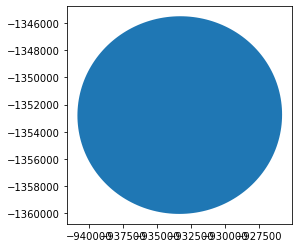

In [3]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'

#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

print(crs)
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()

plt.show()


**load chl_oc3 data for the AMP**

In [4]:
query = {'geopolygon': geom,
         'output_crs': 'EPSG:3577',
         'resolution': (-1300,1300)
         }

In [5]:
time1 = datetime.now()
data = dc.load(product='modis_oc_1d', measurements=(['chl_oc3']), **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:20:28.827979 to finish


**create a mask for the area covered by the AMP polygon**

In [6]:
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs) for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
data = data.where(mask)

In [7]:
data = mask_invalid_data(data)

In [8]:
# note the time dimension: 6214
data

<xarray.Dataset>
Dimensions:  (time: 6214, x: 12, y: 13)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * y        (y) float64 -1.345e+06 -1.346e+06 ... -1.359e+06 -1.36e+06
  * x        (x) float64 -9.406e+05 -9.392e+05 ... -9.276e+05 -9.262e+05
Data variables:
    chl_oc3  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

In [9]:
data1 = data.copy(deep=True)
x = data1.chl_oc3
# the chl values greater than 5.0 mg/m3 are likely over-estimated; these values are reset to 5.0 mg/m3
x = x.where((x < 5) | (np.isnan(x)),5)
data1['chl_oc3'] = x

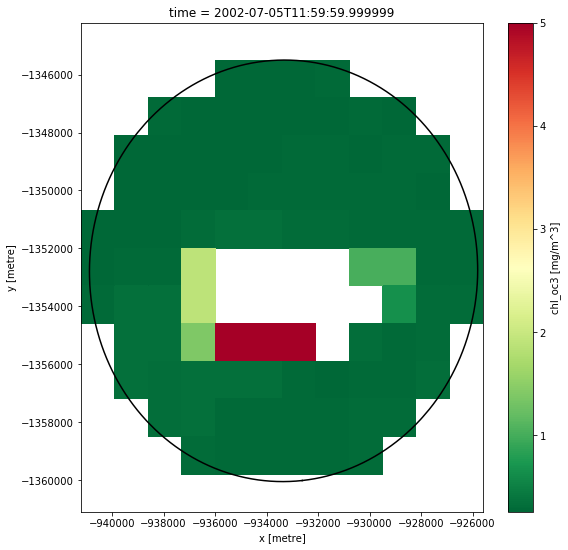

In [10]:
#plot polygon to check it looks ok

import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(9,9))

for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
data1.chl_oc3[1].plot(cmap='RdYlGn_r')

**the pad function for linear interpolation of missing data in a time series**

In [11]:
import numpy as np
import scipy.ndimage as ndimage
def pad(data, maxPadLength=False):
    '''

    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data	     Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015

    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded


## conduct zonal statstists

**conduct zonal statistics for all chl_oc3 data (data), convert the results to a DataFrame**

**in doing so, we obtained the daily chl time-series of the AMP**

In [12]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
i = 0
propertiesList = []
dateList = []
while i < data1['chl_oc3'].time.size:
    date = str(data1['chl_oc3'].time[i].data)[:10]
    print(date)
    dateList.append(date)
    chl = data1.chl_oc3[i].data
    # conduct zonal statistics
    stats = zonal_stats(poly_path,chl,affine=data1.affine,stats=['min','max','mean','range','median','std','sum','count'],geojson_out=True)
    
    propertiesList.append(stats[0]['properties'])    
    
    i = i + 1
chlDF = pd.DataFrame(propertiesList)
chlDF['date']=dateList
chlDF.set_index('date',inplace=True)

2002-07-04
2002-07-05
2002-07-06
2002-07-07
2002-07-08
2002-07-09
2002-07-10


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


2002-07-11
2002-07-12
2002-07-13
2002-07-14
2002-07-15
2002-07-16
2002-07-17
2002-07-18
2002-07-19
2002-07-20
2002-07-21
2002-07-22
2002-07-23
2002-07-24
2002-07-25
2002-07-26
2002-07-27
2002-07-28
2002-07-29
2002-08-07
2002-08-08
2002-08-09
2002-08-10
2002-08-11
2002-08-12
2002-08-13
2002-08-14
2002-08-15
2002-08-16
2002-08-17
2002-08-18
2002-08-19
2002-08-20
2002-08-21
2002-08-22
2002-08-23
2002-08-24
2002-08-25
2002-08-26
2002-08-27
2002-08-28
2002-08-29
2002-08-30
2002-08-31
2002-09-01
2002-09-02
2002-09-03
2002-09-04
2002-09-05
2002-09-06
2002-09-07
2002-09-08
2002-09-09
2002-09-10
2002-09-11
2002-09-12
2002-09-13
2002-09-14
2002-09-15
2002-09-16
2002-09-17
2002-09-18
2002-09-19
2002-09-20
2002-09-21
2002-09-22
2002-09-23
2002-09-24
2002-09-25
2002-09-26
2002-09-27
2002-09-28
2002-09-29
2002-09-30
2002-10-01
2002-10-02
2002-10-03
2002-10-04
2002-10-05
2002-10-06
2002-10-07
2002-10-08
2002-10-09
2002-10-10
2002-10-11
2002-10-12
2002-10-13
2002-10-14
2002-10-15
2002-10-16
2002-10-17

2004-08-03
2004-08-04
2004-08-05
2004-08-06
2004-08-07
2004-08-08
2004-08-09
2004-08-10
2004-08-11
2004-08-12
2004-08-13
2004-08-14
2004-08-15
2004-08-16
2004-08-17
2004-08-18
2004-08-19
2004-08-20
2004-08-21
2004-08-22
2004-08-23
2004-08-24
2004-08-25
2004-08-26
2004-08-27
2004-08-28
2004-08-29
2004-08-30
2004-08-31
2004-09-01
2004-09-02
2004-09-03
2004-09-04
2004-09-05
2004-09-06
2004-09-07
2004-09-08
2004-09-09
2004-09-10
2004-09-11
2004-09-12
2004-09-13
2004-09-14
2004-09-15
2004-09-16
2004-09-17
2004-09-18
2004-09-19
2004-09-20
2004-09-21
2004-09-22
2004-09-23
2004-09-24
2004-09-25
2004-09-26
2004-09-27
2004-09-28
2004-09-29
2004-09-30
2004-10-01
2004-10-02
2004-10-03
2004-10-04
2004-10-05
2004-10-06
2004-10-07
2004-10-08
2004-10-09
2004-10-10
2004-10-11
2004-10-12
2004-10-13
2004-10-14
2004-10-15
2004-10-16
2004-10-17
2004-10-18
2004-10-19
2004-10-20
2004-10-21
2004-10-22
2004-10-23
2004-10-24
2004-10-25
2004-10-26
2004-10-27
2004-10-28
2004-10-29
2004-10-30
2004-10-31
2004-11-01

2006-08-23
2006-08-24
2006-08-25
2006-08-26
2006-08-27
2006-08-28
2006-08-29
2006-08-30
2006-08-31
2006-09-01
2006-09-02
2006-09-03
2006-09-04
2006-09-05
2006-09-06
2006-09-07
2006-09-08
2006-09-09
2006-09-10
2006-09-11
2006-09-12
2006-09-13
2006-09-14
2006-09-15
2006-09-16
2006-09-17
2006-09-18
2006-09-19
2006-09-20
2006-09-21
2006-09-22
2006-09-23
2006-09-24
2006-09-25
2006-09-26
2006-09-27
2006-09-28
2006-09-29
2006-09-30
2006-10-01
2006-10-02
2006-10-03
2006-10-04
2006-10-05
2006-10-06
2006-10-07
2006-10-08
2006-10-09
2006-10-10
2006-10-11
2006-10-12
2006-10-13
2006-10-14
2006-10-15
2006-10-16
2006-10-17
2006-10-18
2006-10-19
2006-10-20
2006-10-21
2006-10-22
2006-10-23
2006-10-24
2006-10-25
2006-10-26
2006-10-27
2006-10-28
2006-10-29
2006-10-30
2006-10-31
2006-11-01
2006-11-02
2006-11-03
2006-11-04
2006-11-05
2006-11-06
2006-11-07
2006-11-08
2006-11-09
2006-11-10
2006-11-11
2006-11-12
2006-11-13
2006-11-14
2006-11-15
2006-11-16
2006-11-17
2006-11-18
2006-11-19
2006-11-20
2006-11-21

2008-09-09
2008-09-10
2008-09-11
2008-09-12
2008-09-13
2008-09-14
2008-09-15
2008-09-16
2008-09-17
2008-09-18
2008-09-19
2008-09-20
2008-09-21
2008-09-22
2008-09-23
2008-09-24
2008-09-25
2008-09-26
2008-09-27
2008-09-28
2008-09-29
2008-09-30
2008-10-01
2008-10-02
2008-10-03
2008-10-04
2008-10-05
2008-10-06
2008-10-07
2008-10-08
2008-10-09
2008-10-10
2008-10-11
2008-10-12
2008-10-13
2008-10-14
2008-10-15
2008-10-16
2008-10-17
2008-10-18
2008-10-19
2008-10-20
2008-10-21
2008-10-22
2008-10-23
2008-10-24
2008-10-25
2008-10-26
2008-10-27
2008-10-28
2008-10-29
2008-10-30
2008-10-31
2008-11-01
2008-11-02
2008-11-03
2008-11-04
2008-11-05
2008-11-06
2008-11-07
2008-11-08
2008-11-09
2008-11-10
2008-11-11
2008-11-12
2008-11-13
2008-11-14
2008-11-15
2008-11-16
2008-11-17
2008-11-18
2008-11-19
2008-11-20
2008-11-21
2008-11-22
2008-11-23
2008-11-24
2008-11-25
2008-11-26
2008-11-27
2008-11-28
2008-11-29
2008-11-30
2008-12-01
2008-12-02
2008-12-03
2008-12-04
2008-12-05
2008-12-06
2008-12-07
2008-12-08

2010-09-30
2010-10-01
2010-10-02
2010-10-03
2010-10-04
2010-10-05
2010-10-06
2010-10-07
2010-10-08
2010-10-09
2010-10-10
2010-10-11
2010-10-12
2010-10-13
2010-10-14
2010-10-15
2010-10-16
2010-10-17
2010-10-18
2010-10-19
2010-10-20
2010-10-21
2010-10-22
2010-10-23
2010-10-24
2010-10-25
2010-10-26
2010-10-27
2010-10-28
2010-10-29
2010-10-30
2010-10-31
2010-11-01
2010-11-02
2010-11-03
2010-11-04
2010-11-05
2010-11-06
2010-11-07
2010-11-08
2010-11-09
2010-11-10
2010-11-11
2010-11-12
2010-11-13
2010-11-14
2010-11-15
2010-11-16
2010-11-17
2010-11-18
2010-11-19
2010-11-20
2010-11-21
2010-11-22
2010-11-23
2010-11-24
2010-11-25
2010-11-26
2010-11-27
2010-11-28
2010-11-29
2010-11-30
2010-12-01
2010-12-02
2010-12-03
2010-12-04
2010-12-05
2010-12-06
2010-12-07
2010-12-08
2010-12-09
2010-12-10
2010-12-11
2010-12-12
2010-12-13
2010-12-14
2010-12-15
2010-12-16
2010-12-17
2010-12-18
2010-12-19
2010-12-20
2010-12-21
2010-12-22
2010-12-23
2010-12-24
2010-12-25
2010-12-26
2010-12-27
2010-12-28
2010-12-29

2012-10-16
2012-10-17
2012-10-18
2012-10-19
2012-10-20
2012-10-21
2012-10-22
2012-10-23
2012-10-24
2012-10-25
2012-10-26
2012-10-27
2012-10-28
2012-10-29
2012-10-30
2012-10-31
2012-11-01
2012-11-02
2012-11-03
2012-11-04
2012-11-05
2012-11-06
2012-11-07
2012-11-08
2012-11-09
2012-11-10
2012-11-11
2012-11-12
2012-11-13
2012-11-14
2012-11-15
2012-11-16
2012-11-17
2012-11-18
2012-11-19
2012-11-20
2012-11-21
2012-11-22
2012-11-23
2012-11-24
2012-11-25
2012-11-26
2012-11-27
2012-11-28
2012-11-29
2012-11-30
2012-12-01
2012-12-02
2012-12-03
2012-12-04
2012-12-05
2012-12-06
2012-12-07
2012-12-08
2012-12-09
2012-12-10
2012-12-11
2012-12-12
2012-12-13
2012-12-14
2012-12-15
2012-12-16
2012-12-17
2012-12-18
2012-12-19
2012-12-20
2012-12-21
2012-12-22
2012-12-23
2012-12-24
2012-12-25
2012-12-26
2012-12-27
2012-12-28
2012-12-29
2012-12-30
2012-12-31
2013-01-01
2013-01-02
2013-01-03
2013-01-04
2013-01-05
2013-01-06
2013-01-07
2013-01-08
2013-01-09
2013-01-10
2013-01-11
2013-01-12
2013-01-13
2013-01-14

2014-11-04
2014-11-05
2014-11-06
2014-11-07
2014-11-08
2014-11-09
2014-11-10
2014-11-11
2014-11-12
2014-11-13
2014-11-14
2014-11-15
2014-11-16
2014-11-17
2014-11-18
2014-11-19
2014-11-20
2014-11-21
2014-11-22
2014-11-23
2014-11-24
2014-11-25
2014-11-26
2014-11-27
2014-11-28
2014-11-29
2014-11-30
2014-12-01
2014-12-02
2014-12-03
2014-12-04
2014-12-05
2014-12-06
2014-12-07
2014-12-08
2014-12-09
2014-12-10
2014-12-11
2014-12-12
2014-12-13
2014-12-14
2014-12-15
2014-12-16
2014-12-17
2014-12-18
2014-12-19
2014-12-20
2014-12-21
2014-12-22
2014-12-23
2014-12-24
2014-12-25
2014-12-26
2014-12-27
2014-12-28
2014-12-29
2014-12-30
2014-12-31
2015-01-01
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07
2015-01-08
2015-01-09
2015-01-10
2015-01-11
2015-01-12
2015-01-13
2015-01-14
2015-01-15
2015-01-16
2015-01-17
2015-01-18
2015-01-19
2015-01-20
2015-01-21
2015-01-22
2015-01-23
2015-01-24
2015-01-25
2015-01-26
2015-01-27
2015-01-28
2015-01-29
2015-01-30
2015-01-31
2015-02-01
2015-02-02

2016-11-19
2016-11-20
2016-11-21
2016-11-22
2016-11-23
2016-11-24
2016-11-25
2016-11-26
2016-11-27
2016-11-28
2016-11-29
2016-11-30
2016-12-01
2016-12-02
2016-12-03
2016-12-04
2016-12-05
2016-12-06
2016-12-07
2016-12-08
2016-12-09
2016-12-10
2016-12-11
2016-12-12
2016-12-13
2016-12-14
2016-12-15
2016-12-16
2016-12-17
2016-12-18
2016-12-19
2016-12-20
2016-12-21
2016-12-22
2016-12-23
2016-12-24
2016-12-25
2016-12-26
2016-12-27
2016-12-28
2016-12-29
2016-12-30
2016-12-31
2017-01-01
2017-01-02
2017-01-03
2017-01-04
2017-01-05
2017-01-06
2017-01-07
2017-01-08
2017-01-09
2017-01-10
2017-01-11
2017-01-12
2017-01-13
2017-01-14
2017-01-15
2017-01-16
2017-01-17
2017-01-18
2017-01-19
2017-01-20
2017-01-21
2017-01-22
2017-01-23
2017-01-24
2017-01-25
2017-01-26
2017-01-27
2017-01-28
2017-01-29
2017-01-30
2017-01-31
2017-02-01
2017-02-02
2017-02-03
2017-02-04
2017-02-05
2017-02-06
2017-02-07
2017-02-08
2017-02-09
2017-02-10
2017-02-11
2017-02-12
2017-02-13
2017-02-14
2017-02-15
2017-02-16
2017-02-17

2018-12-07
2018-12-08
2018-12-09
2018-12-10
2018-12-11
2018-12-12
2018-12-13
2018-12-14
2018-12-15
2018-12-16
2018-12-17
2018-12-18
2018-12-19
2018-12-20
2018-12-21
2018-12-22
2018-12-23
2018-12-24
2018-12-25
2018-12-26
2018-12-27
2018-12-28
2018-12-29
2018-12-30
2018-12-31
2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05
2019-03-06
2019-03-07

In [22]:
chlDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6214 entries, 2002-07-04 to 2019-07-22
Data columns (total 11 columns):
MPA_NAME    6214 non-null object
network     6214 non-null object
area        6214 non-null float64
count       6214 non-null int64
min         3009 non-null float64
max         3009 non-null float64
mean        3009 non-null float64
sum         3009 non-null float64
std         3009 non-null float64
median      3009 non-null float64
range       3009 non-null float64
dtypes: float64(8), int64(1), object(2)
memory usage: 582.6+ KB


In [13]:
chlDF.head(10)

,MPA_NAME,network,area,count,min,max,mean,sum,std,median,range
date,,,,,,,,,,,
2002-07-04,Cartier Island,North-west,172.374499,100,0.219028,3.283521,0.491131,49.113102,0.601465,0.284365,3.064493
2002-07-05,Cartier Island,North-west,172.374499,92,0.256408,5.000000,0.510303,46.947833,0.870673,0.287353,4.743592
2002-07-06,Cartier Island,North-west,172.374499,96,0.147109,5.000000,0.682126,65.484103,1.109953,0.405910,4.852891
2002-07-07,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-07-08,Cartier Island,North-west,172.374499,96,0.237713,5.000000,0.529399,50.822267,0.724972,0.366807,4.762287
2002-07-09,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-07-10,Cartier Island,North-west,172.374499,98,0.221449,2.752042,0.435933,42.721388,0.525915,0.276448,2.530592
2002-07-11,Cartier Island,North-west,172.374499,98,0.193791,2.837569,0.418720,41.034538,0.363317,0.291428,2.643778
2002-07-12,Cartier Island,North-west,172.374499,99,0.234910,2.466493,0.463125,45.849338,0.508654,0.295693,2.231583


**plot the daily mean and min chl time series for the AMP**

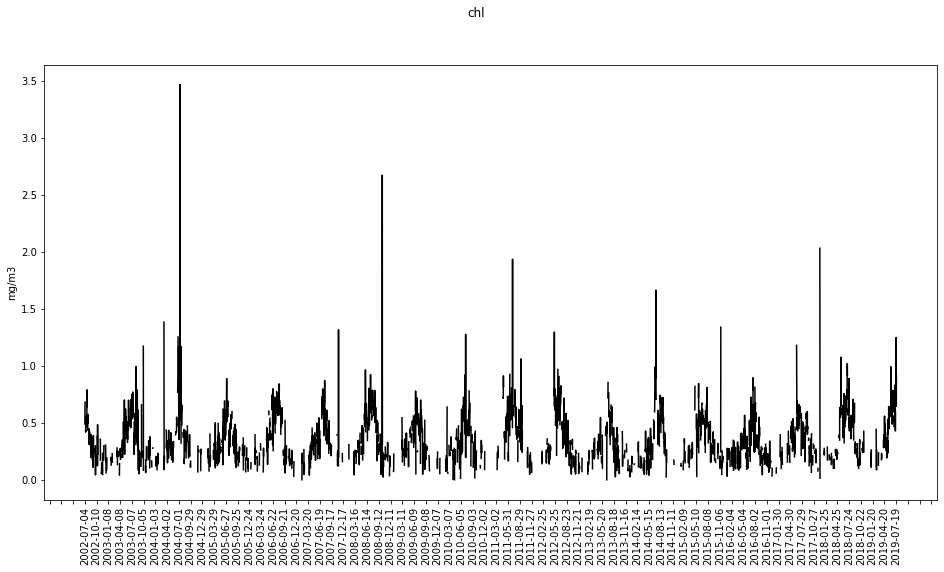

In [14]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(chlDF.index.values,chlDF['mean'].values,color='black')
#ax.plot(chlDF.index.values,chlDF['min'].values,color='blue')
#ax.plot(chlDF.index.values,chlDF['max'].values,color='red')
ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.set_ylabel('mg/m3')
fig.suptitle('chl')

plt.show()

**apply interpolation on the daily mean, min and max CHL time-series**

In [15]:
meanI = pad(chlDF['mean'].values,maxPadLength=False)
minI = pad(chlDF['min'].values,maxPadLength=False)
maxI = pad(chlDF['max'].values,maxPadLength=False)

In [16]:
chlDF['meanI'] = meanI
chlDF['minI'] = minI
chlDF['maxI'] = maxI

**plot the interploated daily time-series**

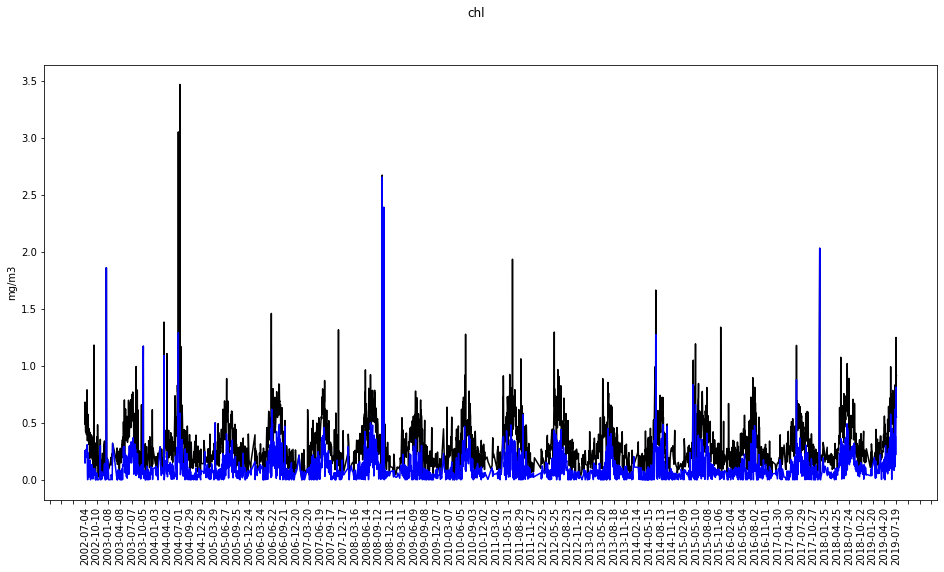

In [17]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(chlDF.index.values,chlDF['meanI'].values,color='black')
ax.plot(chlDF.index.values,chlDF['minI'].values,color='blue')
#ax.plot(chlDF.index.values,chlDF['maxI'].values,color='red')
ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.set_ylabel('mg/m3')
fig.suptitle('chl')

plt.show()

**plot and fit a linear trend line to the daily time-series**

                            OLS Regression Results                            
Dep. Variable:                  meanI   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.781
Date:                Tue, 25 Feb 2020   Prob (F-statistic):              0.182
Time:                        10:40:55   Log-Likelihood:                 1092.7
No. Observations:                6214   AIC:                            -2181.
Df Residuals:                    6212   BIC:                            -2168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2958      0.005     57.429      0.0

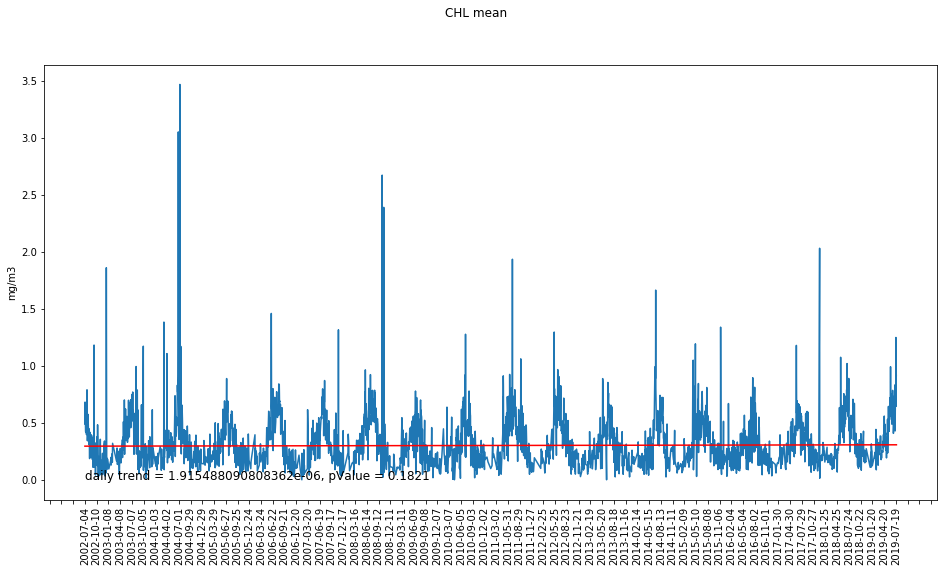

In [18]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,chlDF['meanI'].size+1,1)
chlDF['ind'] = ind

meanFit = sm.ols(formula='meanI ~ ind', data=chlDF).fit()
print(meanFit.summary())

predict = meanFit.predict(chlDF)
chlDF['mean_fitted'] = predict

#rate = (chlDF['mean_fitted'].max() - chlDF['mean_fitted'].min()) / chlDF['mean_fitted'].size
rate = meanFit.params[1]
pValue = round(meanFit.pvalues[1],4)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = chlDF.index[0]
textY = chlDF['meanI'].min()
plt.text(textX,textY,"daily trend = " + str(rate) + ", pValue = " + str(pValue),fontsize=12)
ax.plot(chlDF.index.values,chlDF['meanI'].values)

ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.plot(chlDF.ind, chlDF.mean_fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL mean')

plt.show()

                            OLS Regression Results                            
Dep. Variable:                   minI   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6531
Date:                Tue, 25 Feb 2020   Prob (F-statistic):              0.419
Time:                        10:41:07   Log-Likelihood:                 4193.8
No. Observations:                6214   AIC:                            -8384.
Df Residuals:                    6212   BIC:                            -8370.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1048      0.003     33.512      0.0

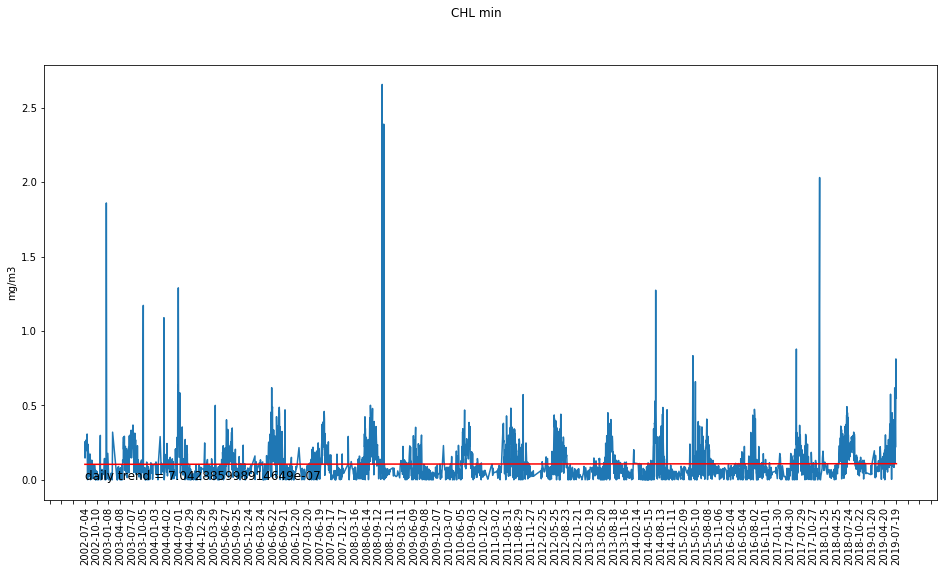

In [19]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm


minFit = sm.ols(formula='minI ~ ind', data=chlDF).fit()
print(minFit.summary())

predict = minFit.predict(chlDF)
chlDF['min_fitted'] = predict

rate = minFit.params[1]

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = chlDF.index[0]
textY = chlDF['minI'].min()
plt.text(textX,textY,"daily trend = " + str(rate),fontsize=12)
ax.plot(chlDF.index.values,chlDF['minI'].values)

ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.plot(chlDF.ind, chlDF.min_fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL min')

plt.show()

**conduct T test and F test on the linear trend (e.g., the ind param in this case)**

**add year, month, season and yearmonth column**

In [21]:
yearList = []
monthList = []
seasonList = []
yearmonthList = []
for date in chlDF.index:
    year = date[:4]
    month = date[5:7]
    if month in ['12','01','02']:
        season = 'summer'
    elif month in ['03','04','05']:
        season = 'autumn'
    elif month in ['06','07','08']:
        season = 'winter'
    else:
        season = 'spring'
    yearList.append(year)
    monthList.append(month)
    seasonList.append(season)
    yearmonth = year+month
    yearmonthList.append(yearmonth)
chlDF['year'] = yearList
chlDF['month'] = monthList
chlDF['season'] = seasonList
chlDF['yearmonth'] = yearmonthList

In [22]:
chlDF.head(10)

,MPA_NAME,network,area,count,min,max,mean,sum,std,median,...,meanI,minI,maxI,ind,mean_fitted,min_fitted,year,month,season,yearmonth
date,,,,,,,,,,,,,,,,,,,,,
2002-07-04,Cartier Island,North-west,172.374499,100,0.219028,3.283521,0.491131,49.113102,0.601465,0.284365,...,0.491131,0.219028,3.283521,1,0.295797,0.104794,2002,07,winter,200207
2002-07-05,Cartier Island,North-west,172.374499,92,0.256408,5.000000,0.510303,46.947833,0.870673,0.287353,...,0.510303,0.256408,5.000000,2,0.295799,0.104795,2002,07,winter,200207
2002-07-06,Cartier Island,North-west,172.374499,96,0.147109,5.000000,0.682126,65.484103,1.109953,0.405910,...,0.682126,0.147109,5.000000,3,0.295800,0.104795,2002,07,winter,200207
2002-07-07,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.605762,0.192411,5.000000,4,0.295802,0.104796,2002,07,winter,200207
2002-07-08,Cartier Island,North-west,172.374499,96,0.237713,5.000000,0.529399,50.822267,0.724972,0.366807,...,0.529399,0.237713,5.000000,5,0.295804,0.104797,2002,07,winter,200207
2002-07-09,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.482666,0.229581,3.876021,6,0.295806,0.104797,2002,07,winter,200207
2002-07-10,Cartier Island,North-west,172.374499,98,0.221449,2.752042,0.435933,42.721388,0.525915,0.276448,...,0.435933,0.221449,2.752042,7,0.295808,0.104798,2002,07,winter,200207
2002-07-11,Cartier Island,North-west,172.374499,98,0.193791,2.837569,0.418720,41.034538,0.363317,0.291428,...,0.418720,0.193791,2.837569,8,0.295810,0.104799,2002,07,winter,200207
2002-07-12,Cartier Island,North-west,172.374499,99,0.234910,2.466493,0.463125,45.849338,0.508654,0.295693,...,0.463125,0.234910,2.466493,9,0.295812,0.104800,2002,07,winter,200207


**group by year**

**the describe function generates a dataframe with the groupping results (time-series of annual mean/min/max)**

In [23]:
x = chlDF['mean'].groupby(chlDF['year'])
yearmeanCHLDF = x.describe()
x = chlDF['min'].groupby(chlDF['year'])
yearminCHLDF = x.describe()
x = chlDF['max'].groupby(chlDF['year'])
yearmaxCHLDF = x.describe()
x = chlDF['std'].groupby(chlDF['year'])
yearstdCHLDF = x.describe()

x = chlDF['mean'].groupby(chlDF['yearmonth'])
yearmonthmeanCHLDF = x.describe()

x = chlDF['std'].groupby(chlDF['yearmonth'])
yearmonthstdCHLDF = x.describe()

In [25]:
yearstdCHLDF

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2002,95.0,0.448176,0.277519,0.0,0.305385,0.449428,0.586004,1.257836
2003,184.0,0.411861,0.246310,0.0,0.280934,0.402087,0.527602,1.494982
2004,181.0,0.413871,0.251854,0.0,0.250878,0.407483,0.539592,1.771046
2005,186.0,0.385286,0.227201,0.0,0.247094,0.399119,0.512631,1.281602
2006,166.0,0.399736,0.243849,0.0,0.243516,0.410038,0.555694,1.217752
2007,170.0,0.409835,0.245815,0.0,0.250059,0.442763,0.539041,1.164044
2008,183.0,0.461457,0.241717,0.0,0.332346,0.470159,0.592414,1.329555
2009,175.0,0.423470,0.266447,0.0,0.269364,0.441144,0.561334,1.244279
2010,163.0,0.369423,0.261302,0.0,0.167840,0.392479,0.503446,1.856764


**year 2002 and 2019 are partial years and should not be included**

In [29]:
yearmeanCHLDF1 = yearmeanCHLDF.loc['2003':'2018']
yearminCHLDF1 = yearminCHLDF.loc['2003':'2018']
yearmaxCHLDF1 = yearmaxCHLDF.loc['2003':'2018']
yearstdCHLDF1 = yearstdCHLDF.loc['2003':'2018']

yearmonthmeanCHLDF1 = yearmonthmeanCHLDF.loc['200301':'201812']
yearmonthstdCHLDF1 = yearmonthstdCHLDF.loc['200301':'201812']

In [30]:
yearmonthmeanCHLDF1

,count,mean,std,min,25%,50%,75%,max
yearmonth,,,,,,,,
200301,5.0,0.155767,0.041706,0.095971,0.130202,0.176027,0.178350,0.198286
200302,3.0,0.235284,0.082880,0.155371,0.192505,0.229638,0.275241,0.320843
200303,13.0,0.215254,0.040828,0.135574,0.204962,0.214255,0.247036,0.279516
200304,21.0,0.215436,0.073785,0.042413,0.195920,0.217093,0.251495,0.351847
200305,22.0,0.459959,0.120908,0.224677,0.366215,0.485081,0.544817,0.700818
...,...,...,...,...,...,...,...,...
201808,21.0,0.498392,0.084474,0.320027,0.480850,0.508044,0.545972,0.706736
201809,23.0,0.333049,0.142788,0.123927,0.244444,0.302166,0.371353,0.671083
201810,16.0,0.236461,0.096474,0.084724,0.156982,0.257946,0.302276,0.405400


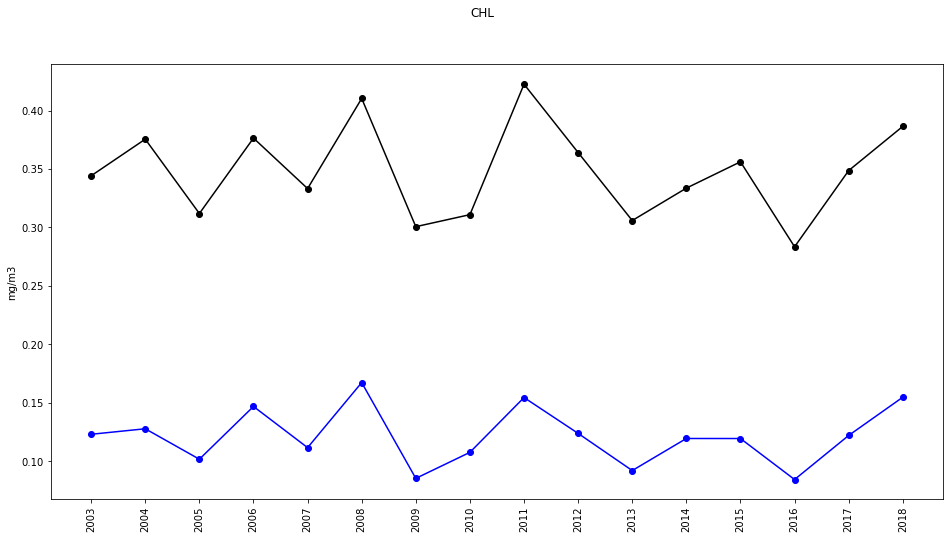

In [31]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(yearmeanCHLDF1.index.values,yearmeanCHLDF1['mean'].values,marker='o',color='black')
ax.plot(yearminCHLDF1.index.values,yearminCHLDF1['mean'].values,marker='o',color='blue')
#ax.plot(yearmaxCHLDF1.index.values,yearmaxCHLDF1['mean'].values,marker='o',color='red')

ax.set_ylabel('mg/m3')
fig.suptitle('CHL')

plt.show()

**plot the annual mean CHL time-series and the (temporal) standard deviation**

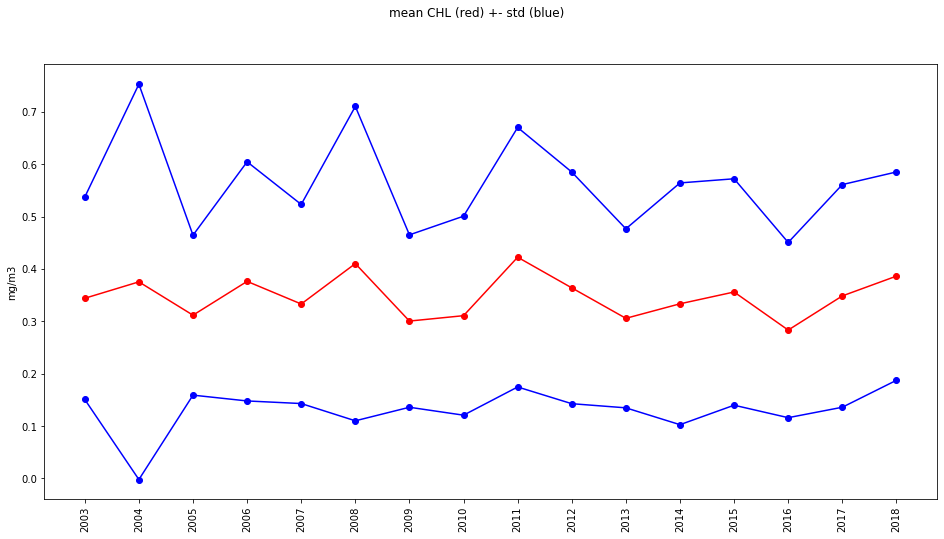

In [33]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(yearmeanCHLDF1.index.values,yearmeanCHLDF1['mean'].values,marker='o',color='red')
ax.plot(yearstdCHLDF1.index.values,yearmeanCHLDF1['mean'].values-yearmeanCHLDF1['std'],marker='o',color='blue')
ax.plot(yearstdCHLDF1.index.values,yearmeanCHLDF1['mean'].values+yearmeanCHLDF1['std'],marker='o',color='blue')

ax.set_ylabel('mg/m3')
fig.suptitle('mean CHL (red) +- std (blue)')

plt.show()

**plot daily CHL time-series and the annual mean CHL time-series**

In [36]:
chlDF1 = chlDF.loc['2003-01-01':'2018-12-31']

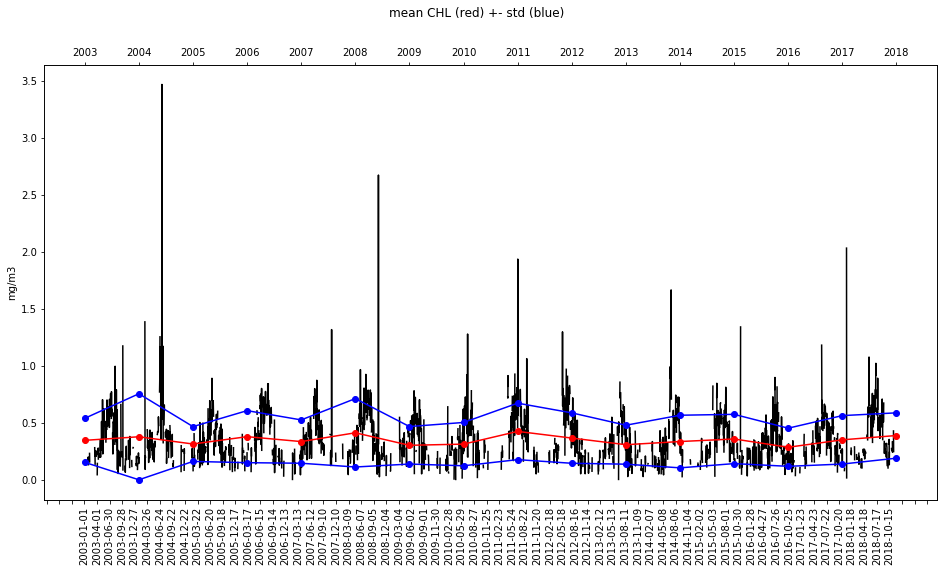

In [70]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax1.plot(chlDF1.index.values,chlDF1['mean'].values,color='black')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(90))

ax2 = ax1.twiny()
ax2.plot(yearmeanCHLDF1.index.values,yearmeanCHLDF1['mean'].values,marker='o',color='red')
ax2.plot(yearstdCHLDF1.index.values,yearmeanCHLDF1['mean'].values-yearmeanCHLDF1['std'],marker='o',color='blue')
ax2.plot(yearstdCHLDF1.index.values,yearmeanCHLDF1['mean'].values+yearmeanCHLDF1['std'],marker='o',color='blue')

ax1.set_ylabel('mg/m3')
fig.suptitle('mean CHL (red) +- std (blue)')

plt.show()

**plot the daily SST time-series and monthly SST time-series**

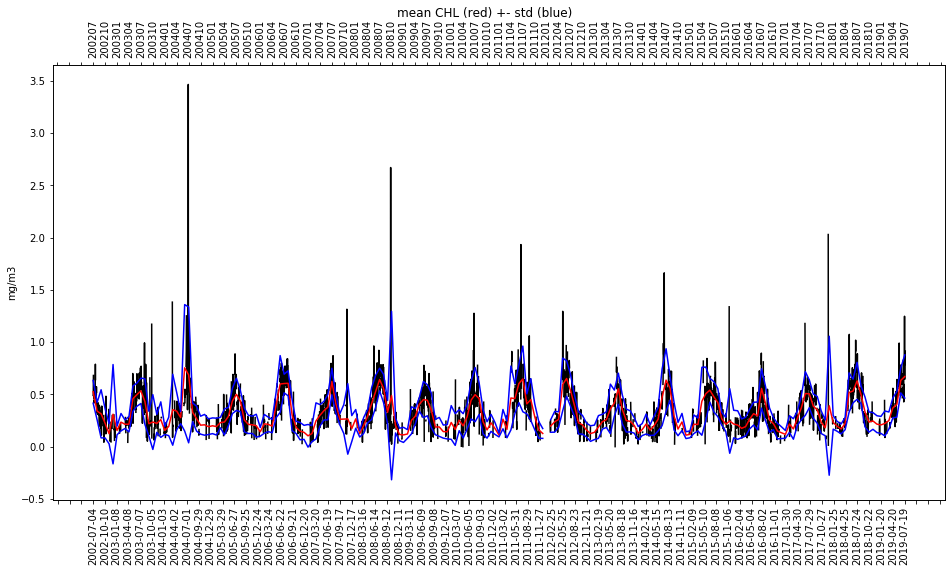

In [71]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')


ax1.plot(chlDF.index.values,chlDF['mean'].values,color='black')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(90))

ax2 = ax1.twiny()
ax2.plot(yearmonthmeanCHLDF.index.values,yearmonthmeanCHLDF['mean'].values,color='red')
ax2.plot(yearmonthstdCHLDF.index.values,yearmonthmeanCHLDF['mean'].values-yearmonthmeanCHLDF['std'],color='blue')
ax2.plot(yearmonthstdCHLDF.index.values,yearmonthmeanCHLDF['mean'].values+yearmonthmeanCHLDF['std'],color='blue')
#ax2.set_xticklabels(yearmonthmeanCHLDF.index.values,rotation="vertical")
plt.xticks(rotation='vertical')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(3))

#ax1.set_xticks(yearmeanCHLDF1.index.values)
ax1.set_ylabel('mg/m3')
fig.suptitle('mean CHL (red) +- std (blue)')



plt.show()

**plot monthly CHL time-series and annual CHL time-series**

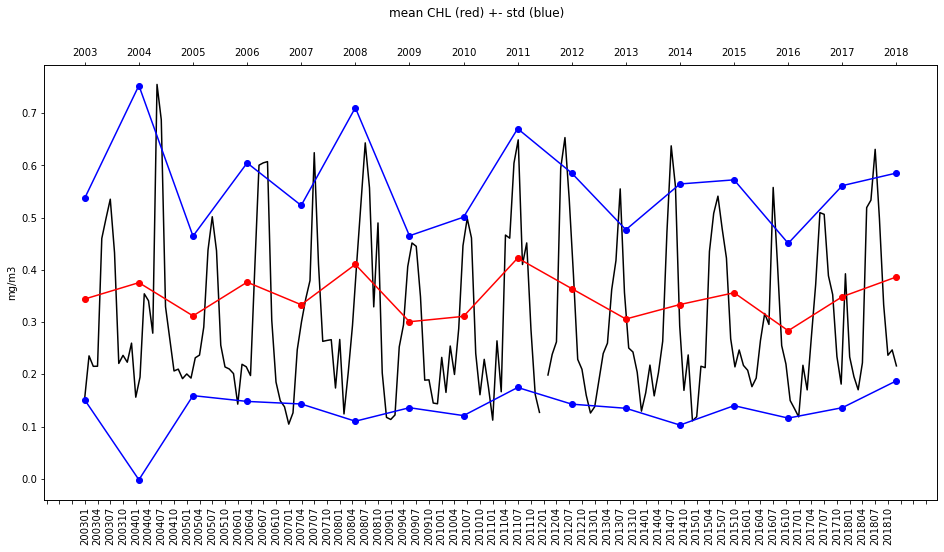

In [72]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')


ax1.plot(yearmonthmeanCHLDF1.index.values,yearmonthmeanCHLDF1['mean'].values,color='black')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax2 = ax1.twiny()
ax2.plot(yearmeanCHLDF1.index.values,yearmeanCHLDF1['mean'].values,marker='o',color='red')
ax2.plot(yearstdCHLDF1.index.values,yearmeanCHLDF1['mean'].values-yearmeanCHLDF1['std'],marker='o',color='blue')
ax2.plot(yearstdCHLDF1.index.values,yearmeanCHLDF1['mean'].values+yearmeanCHLDF1['std'],marker='o',color='blue')

ax1.set_ylabel('mg/m3')
fig.suptitle('mean CHL (red) +- std (blue)')



plt.show()

**plot and fit the time-serie of annual means/mins**

In [46]:
yearstdCHLDF1

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2003,184.0,0.411861,0.246310,0.0,0.280934,0.402087,0.527602,1.494982
2004,181.0,0.413871,0.251854,0.0,0.250878,0.407483,0.539592,1.771046
2005,186.0,0.385286,0.227201,0.0,0.247094,0.399119,0.512631,1.281602
2006,166.0,0.399736,0.243849,0.0,0.243516,0.410038,0.555694,1.217752
2007,170.0,0.409835,0.245815,0.0,0.250059,0.442763,0.539041,1.164044
2008,183.0,0.461457,0.241717,0.0,0.332346,0.470159,0.592414,1.329555
2009,175.0,0.423470,0.266447,0.0,0.269364,0.441144,0.561334,1.244279
2010,163.0,0.369423,0.261302,0.0,0.167840,0.392479,0.503446,1.856764
2011,154.0,0.451883,0.308576,0.0,0.284365,0.450208,0.604134,2.181857


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.065
Method:                 Least Squares   F-statistic:                   0.07877
Date:                Tue, 25 Feb 2020   Prob (F-statistic):              0.783
Time:                        11:28:34   Log-Likelihood:                 29.324
No. Observations:                  16   AIC:                            -54.65
Df Residuals:                      14   BIC:                            -53.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3531      0.022     16.270      0.0

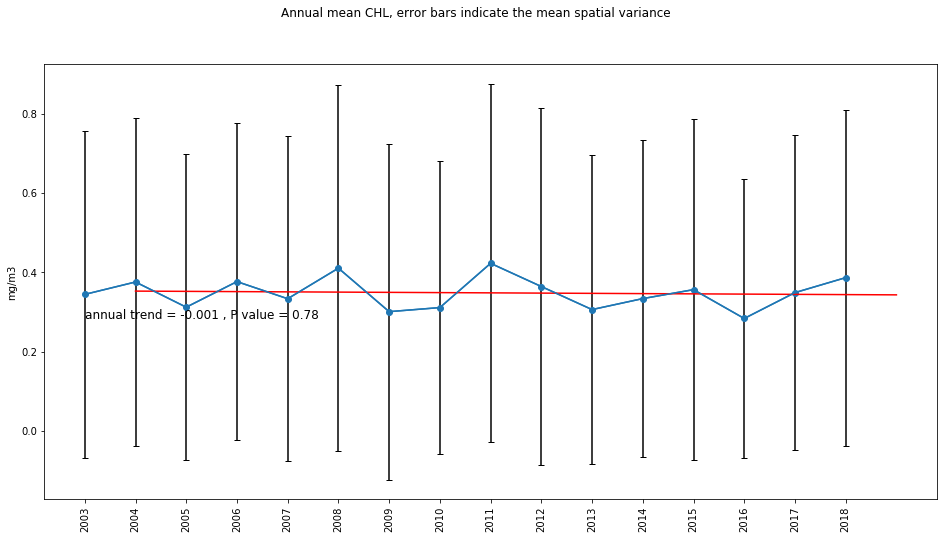

In [45]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearmeanCHLDF1['mean'].size+1,1)
yearmeanCHLDF1['ind'] = ind

yearmeanFit = sm.ols(formula='mean ~ ind', data=yearmeanCHLDF1).fit()
print(yearmeanFit.summary())

predict = yearmeanFit.predict(yearmeanCHLDF1)
yearmeanCHLDF1['fitted'] = predict

rate = round(yearmeanFit.params[1],3)
pValue = round(yearmeanFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearmeanCHLDF1.index[0]
textY = yearmeanCHLDF1['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearmeanCHLDF1.index.values,yearmeanCHLDF1['mean'].values,marker='o')

ax.errorbar(yearmeanCHLDF1.index.values,yearmeanCHLDF1['mean'].values,yerr=yearstdCHLDF1['mean'].values,ecolor="black",
           capsize=3.0)

ax.plot(yearmeanCHLDF1.ind, yearmeanCHLDF1.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('Annual mean CHL, error bars indicate the mean spatial variance')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.065
Method:                 Least Squares   F-statistic:                   0.07877
Date:                Tue, 25 Feb 2020   Prob (F-statistic):              0.783
Time:                        11:28:05   Log-Likelihood:                 29.324
No. Observations:                  16   AIC:                            -54.65
Df Residuals:                      14   BIC:                            -53.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3531      0.022     16.270      0.0

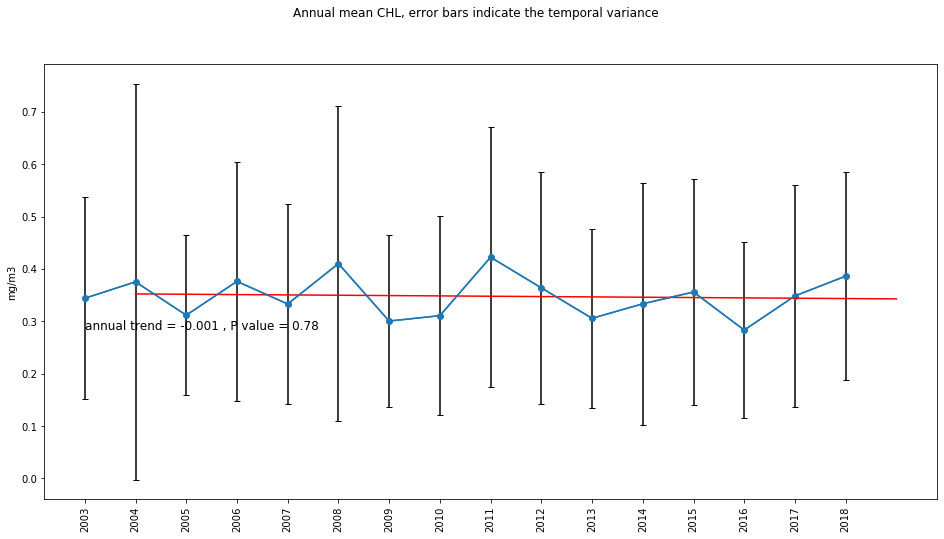

In [44]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearmeanCHLDF1['mean'].size+1,1)
yearmeanCHLDF1['ind'] = ind

yearmeanFit = sm.ols(formula='mean ~ ind', data=yearmeanCHLDF1).fit()
print(yearmeanFit.summary())

predict = yearmeanFit.predict(yearmeanCHLDF1)
yearmeanCHLDF1['fitted'] = predict

rate = round(yearmeanFit.params[1],3)
pValue = round(yearmeanFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearmeanCHLDF1.index[0]
textY = yearmeanCHLDF1['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearmeanCHLDF1.index.values,yearmeanCHLDF1['mean'].values,marker='o')

ax.errorbar(yearmeanCHLDF1.index.values,yearmeanCHLDF1['mean'].values,yerr=yearmeanCHLDF1['std'].values,ecolor="black",
           capsize=3.0)

ax.plot(yearmeanCHLDF1.ind, yearmeanCHLDF1.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('Annual mean CHL, error bars indicate the temporal variance')

plt.show()

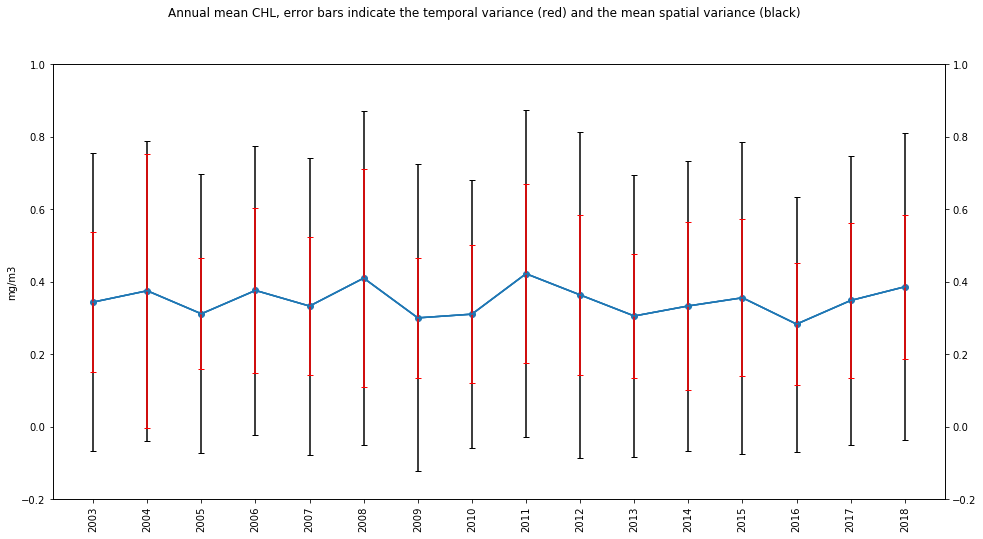

In [54]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')


ax1.plot(yearmeanCHLDF1.index.values,yearmeanCHLDF1['mean'].values,marker='o')
ax1.errorbar(yearmeanCHLDF1.index.values,yearmeanCHLDF1['mean'].values,yerr=yearstdCHLDF1['mean'].values,ecolor="black",
           capsize=3.0)

ax1.set_ylabel('mg/m3')
ax1.set_ylim(ymin=-0.2,ymax=1.0)
ax2 = ax1.twinx()
ax2.errorbar(yearmeanCHLDF1.index.values,yearmeanCHLDF1['mean'].values,yerr=yearmeanCHLDF1['std'].values,ecolor="red",
           capsize=3.0)
ax2.set_ylim(ymin=-0.2,ymax=1.0)
fig.suptitle('Annual mean CHL, error bars indicate the temporal variance (red) and the mean spatial variance (black)')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.068
Method:                 Least Squares   F-statistic:                   0.04296
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.839
Time:                        10:03:59   Log-Likelihood:                 36.983
No. Observations:                  16   AIC:                            -69.97
Df Residuals:                      14   BIC:                            -68.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1237      0.013      9.203      0.0

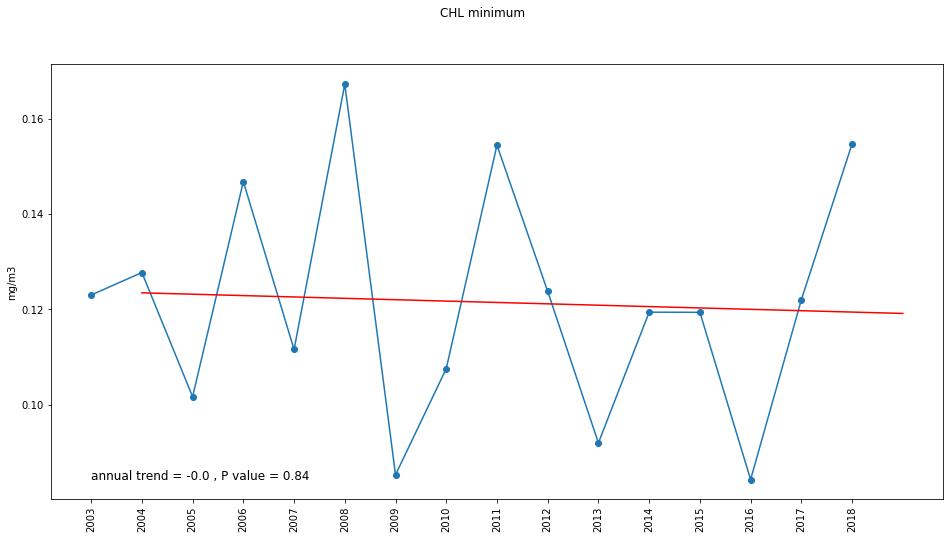

In [85]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearminCHLDF1['mean'].size+1,1)
yearminCHLDF1['ind'] = ind

yearminFit = sm.ols(formula='mean ~ ind', data=yearminCHLDF1).fit()
print(yearminFit.summary())

predict = yearminFit.predict(yearminCHLDF1)
yearminCHLDF1['fitted'] = predict

rate = round(yearminFit.params[1],3)
pValue = round(yearminFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearminCHLDF1.index[0]
textY = yearminCHLDF1['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearminCHLDF1.index.values,yearminCHLDF1['mean'].values,marker='o')


ax.plot(yearminCHLDF1.ind, yearminCHLDF1.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL minimum')

plt.show()

**the T test and F test both indicate that the trend is not statistically significant in this case**

In [43]:
t_test = yearmeanFit.t_test("ind = 0")
print(t_test)
f_test = yearmeanFit.f_test("ind = 0")
print(f_test)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0006      0.002     -0.281      0.783      -0.005       0.004
<F test: F=array([[0.07877008]]), p=0.783076018664705, df_denom=14, df_num=1>


**same analysis based on the interpolated CHL time-series**

In [23]:
x = chlDF['meanI'].groupby(chlDF['year'])
yearmeanICHLDF = x.describe()
x = chlDF['minI'].groupby(chlDF['year'])
yearminICHLDF = x.describe()
x = chlDF['maxI'].groupby(chlDF['year'])
yearmaxICHLDF = x.describe()


yearmeanICHLDF1 = yearmeanICHLDF.loc['2003':'2018']
yearminICHLDF1 = yearminICHLDF.loc['2003':'2018']
yearmaxICHLDF1 = yearmaxICHLDF.loc['2003':'2018']

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.065
Method:                 Least Squares   F-statistic:                   0.07859
Date:                Thu, 13 Feb 2020   Prob (F-statistic):              0.783
Time:                        15:06:12   Log-Likelihood:                 36.158
No. Observations:                  16   AIC:                            -68.32
Df Residuals:                      14   BIC:                            -66.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3025      0.014     21.365      0.0

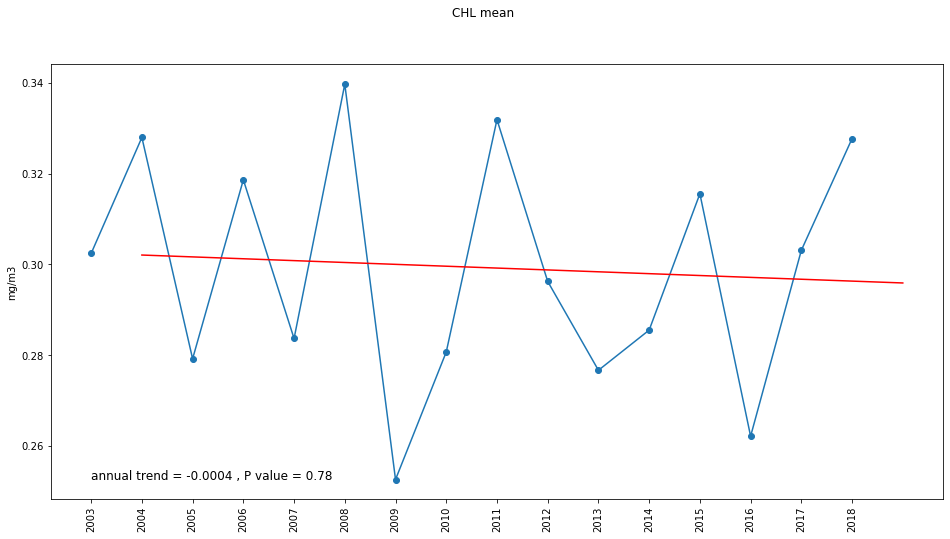

In [26]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearmeanICHLDF1['mean'].size+1,1)
yearmeanICHLDF1['ind'] = ind

yearmeanIFit = sm.ols(formula='mean ~ ind', data=yearmeanICHLDF1).fit()
print(yearmeanIFit.summary())

predict = yearmeanIFit.predict(yearmeanICHLDF1)
yearmeanICHLDF1['fitted'] = predict

rate = round(yearmeanIFit.params[1],4)
pValue = round(yearmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearmeanICHLDF1.index[0]
textY = yearmeanICHLDF1['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearmeanICHLDF1.index.values,yearmeanICHLDF1['mean'].values,marker='o')


ax.plot(yearmeanICHLDF1.ind, yearmeanICHLDF1.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL mean')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                    0.2660
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.614
Time:                        10:04:46   Log-Likelihood:                 40.956
No. Observations:                  16   AIC:                            -77.91
Df Residuals:                      14   BIC:                            -76.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1097      0.010     10.462      0.0

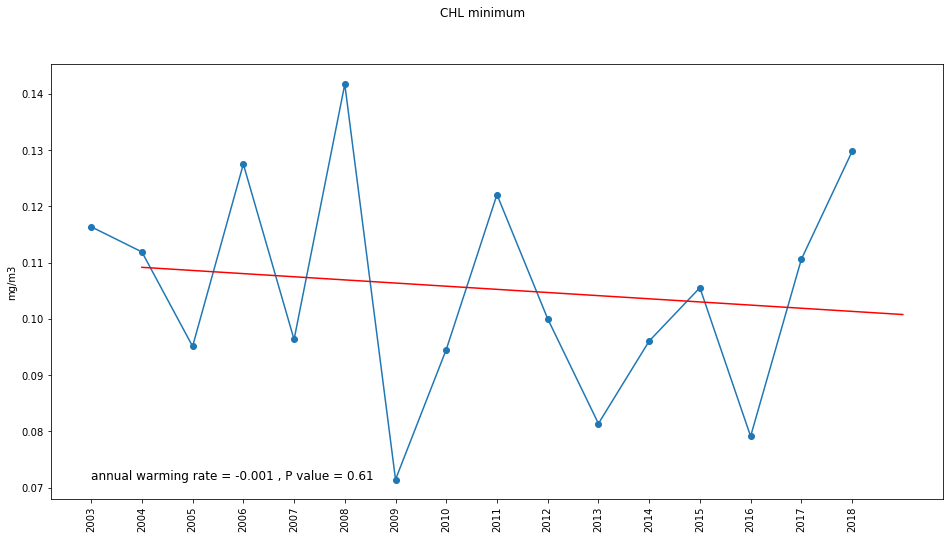

In [87]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearminICHLDF1['mean'].size+1,1)
yearminICHLDF1['ind'] = ind

yearminIFit = sm.ols(formula='mean ~ ind', data=yearminICHLDF1).fit()
print(yearminIFit.summary())

predict = yearminIFit.predict(yearminICHLDF1)
yearminICHLDF1['fitted'] = predict

rate = round(yearminIFit.params[1],3)
pValue = round(yearminIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearminICHLDF1.index[0]
textY = yearminICHLDF1['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearminICHLDF1.index.values,yearminICHLDF1['mean'].values,marker='o')


ax.plot(yearminICHLDF1.ind, yearminICHLDF1.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL minimum')

plt.show()

**variation of monthly means**

In [56]:
x = chlDF['meanI'].groupby(chlDF['month'])
monthmeanICHLDF = x.describe()
x = chlDF['mean'].groupby(chlDF['month'])
monthmeanCHLDF = x.describe()
x = chlDF['std'].groupby(chlDF['month'])
monthstdCHLDF = x.describe()




In [57]:
monthstdCHLDF

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
01,106.0,0.197439,0.163209,0.0,0.024884,0.214857,0.332636,0.580078
02,141.0,0.216583,0.172998,0.0,0.034659,0.241663,0.330814,0.683210
03,196.0,0.280268,0.165127,0.0,0.155808,0.306391,0.393722,0.778488
04,287.0,0.387476,0.182873,0.0,0.298786,0.415570,0.494408,0.998190
05,317.0,0.486982,0.222753,0.0,0.395955,0.501714,0.600365,1.445230
06,339.0,0.529918,0.260673,0.0,0.406167,0.525113,0.645566,1.329555
07,364.0,0.566209,0.272587,0.0,0.440843,0.528655,0.656381,2.181857
08,370.0,0.509353,0.217521,0.0,0.416931,0.490738,0.596747,1.494982
09,319.0,0.398336,0.219365,0.0,0.289701,0.395839,0.525027,1.425494


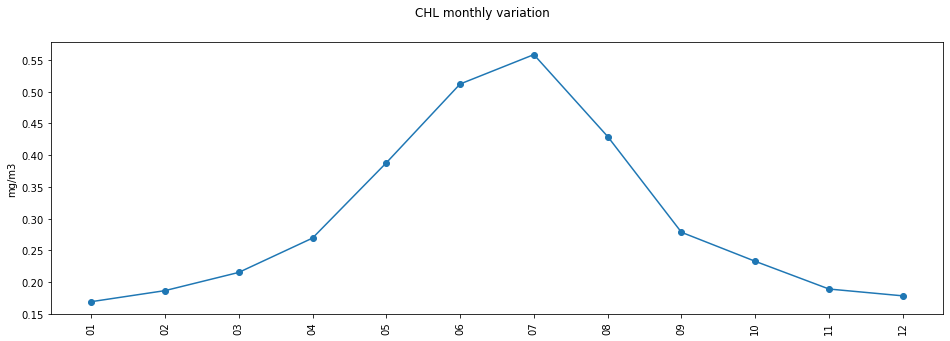

In [29]:
fig, ax = plt.subplots(figsize=(16,5))
plt.xticks(rotation='vertical')


ax.plot(monthmeanICHLDF.index.values,monthmeanICHLDF['mean'].values,marker='o')



ax.set_ylabel('mg/m3')
fig.suptitle('CHL monthly variation')

plt.show()

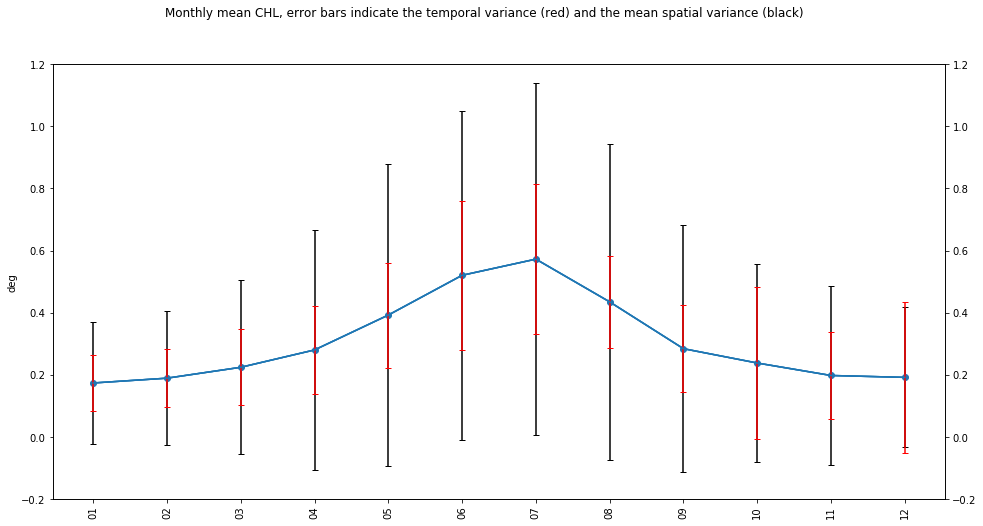

In [62]:
fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')
ax1.plot(monthmeanCHLDF.index.values,monthmeanCHLDF['mean'].values,marker='o')
ax1.errorbar(monthmeanCHLDF.index.values,monthmeanCHLDF['mean'].values,yerr=monthstdCHLDF['mean'].values,ecolor="black",capsize=3.0)
ax1.set_ylabel('deg')
ax1.set_ylim(ymin=-0.2,ymax=1.2)
ax2 = ax1.twinx()
ax2.errorbar(monthmeanCHLDF.index.values,monthmeanCHLDF['mean'].values,yerr=monthmeanCHLDF['std'].values,ecolor="red",capsize=3.0)
ax2.set_ylim(ymin=-0.2,ymax=1.2)
fig.suptitle('Monthly mean CHL, error bars indicate the temporal variance (red) and the mean spatial variance (black)')

plt.show()

**annual time-series of each month**

In [30]:
# note how to deal with multiindex
meanIDF = chlDF[['meanI','year','month']]
x = meanIDF.groupby(['year','month'])
yearmonthmeanICHLDF = x.describe()

idx = pd.IndexSlice
JanmeanICHLDF = yearmonthmeanICHLDF.loc[idx[:,['01']],:]
FebmeanICHLDF = yearmonthmeanICHLDF.loc[idx[:,['02']],:]
MarmeanICHLDF = yearmonthmeanICHLDF.loc[idx[:,['03']],:]
AprmeanICHLDF = yearmonthmeanICHLDF.loc[idx[:,['04']],:]
MaymeanICHLDF = yearmonthmeanICHLDF.loc[idx[:,['05']],:]
JunmeanICHLDF = yearmonthmeanICHLDF.loc[idx[:,['06']],:]
JulmeanICHLDF = yearmonthmeanICHLDF.loc[idx[:,['07']],:]
AugmeanICHLDF = yearmonthmeanICHLDF.loc[idx[:,['08']],:]
SepmeanICHLDF = yearmonthmeanICHLDF.loc[idx[:,['09']],:]
OctmeanICHLDF = yearmonthmeanICHLDF.loc[idx[:,['10']],:]
NovmeanICHLDF = yearmonthmeanICHLDF.loc[idx[:,['11']],:]
DecmeanICHLDF = yearmonthmeanICHLDF.loc[idx[:,['12']],:]
JanmeanICHLDF.reset_index(inplace=True)
JanmeanICHLDF.set_index('year',inplace=True)
x = JanmeanICHLDF.columns.droplevel(level=0)
JanmeanICHLDF.columns=x
FebmeanICHLDF.reset_index(inplace=True)
FebmeanICHLDF.set_index('year',inplace=True)
x = FebmeanICHLDF.columns.droplevel(level=0)
FebmeanICHLDF.columns=x
MarmeanICHLDF.reset_index(inplace=True)
MarmeanICHLDF.set_index('year',inplace=True)
x = MarmeanICHLDF.columns.droplevel(level=0)
MarmeanICHLDF.columns=x
AprmeanICHLDF.reset_index(inplace=True)
AprmeanICHLDF.set_index('year',inplace=True)
x = AprmeanICHLDF.columns.droplevel(level=0)
AprmeanICHLDF.columns=x
MaymeanICHLDF.reset_index(inplace=True)
MaymeanICHLDF.set_index('year',inplace=True)
x = MaymeanICHLDF.columns.droplevel(level=0)
MaymeanICHLDF.columns=x
JunmeanICHLDF.reset_index(inplace=True)
JunmeanICHLDF.set_index('year',inplace=True)
x = JunmeanICHLDF.columns.droplevel(level=0)
JunmeanICHLDF.columns=x
JulmeanICHLDF.reset_index(inplace=True)
JulmeanICHLDF.set_index('year',inplace=True)
x = JulmeanICHLDF.columns.droplevel(level=0)
JulmeanICHLDF.columns=x
AugmeanICHLDF.reset_index(inplace=True)
AugmeanICHLDF.set_index('year',inplace=True)
x = AugmeanICHLDF.columns.droplevel(level=0)
AugmeanICHLDF.columns=x
SepmeanICHLDF.reset_index(inplace=True)
SepmeanICHLDF.set_index('year',inplace=True)
x = SepmeanICHLDF.columns.droplevel(level=0)
SepmeanICHLDF.columns=x
OctmeanICHLDF.reset_index(inplace=True)
OctmeanICHLDF.set_index('year',inplace=True)
x = OctmeanICHLDF.columns.droplevel(level=0)
OctmeanICHLDF.columns=x
NovmeanICHLDF.reset_index(inplace=True)
NovmeanICHLDF.set_index('year',inplace=True)
x = NovmeanICHLDF.columns.droplevel(level=0)
NovmeanICHLDF.columns=x
DecmeanICHLDF.reset_index(inplace=True)
DecmeanICHLDF.set_index('year',inplace=True)
x = DecmeanICHLDF.columns.droplevel(level=0)
DecmeanICHLDF.columns=x

In [54]:
FebmeanICHLDF

,,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,,
2003,02,28.0,0.248142,0.048306,0.155061,0.224833,0.250741,0.285792,0.320843
2004,02,29.0,0.220281,0.060424,0.084090,0.175358,0.248415,0.269094,0.291149
2005,02,28.0,0.179265,0.066681,0.078215,0.151244,0.168477,0.199212,0.401406
2006,02,28.0,0.218039,0.098469,0.078789,0.141692,0.209865,0.274472,0.395413
2007,02,28.0,0.105815,0.058908,0.029314,0.062931,0.085580,0.133590,0.265031
2008,02,29.0,0.121848,0.022498,0.080393,0.103704,0.123684,0.144596,0.148081
2009,02,28.0,0.121365,0.028614,0.085943,0.104669,0.110501,0.117562,0.193047
2010,02,28.0,0.166148,0.113137,0.058901,0.087411,0.157504,0.190132,0.637978
2011,02,28.0,0.206480,0.052106,0.139233,0.172915,0.200156,0.219827,0.368877


**plot and fit annual time-series of each month**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.064
Method:                 Least Squares   F-statistic:                   0.03243
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.859
Time:                        10:06:58   Log-Likelihood:                 27.949
No. Observations:                  17   AIC:                            -51.90
Df Residuals:                      15   BIC:                            -50.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1652      0.025      6.542      0.0

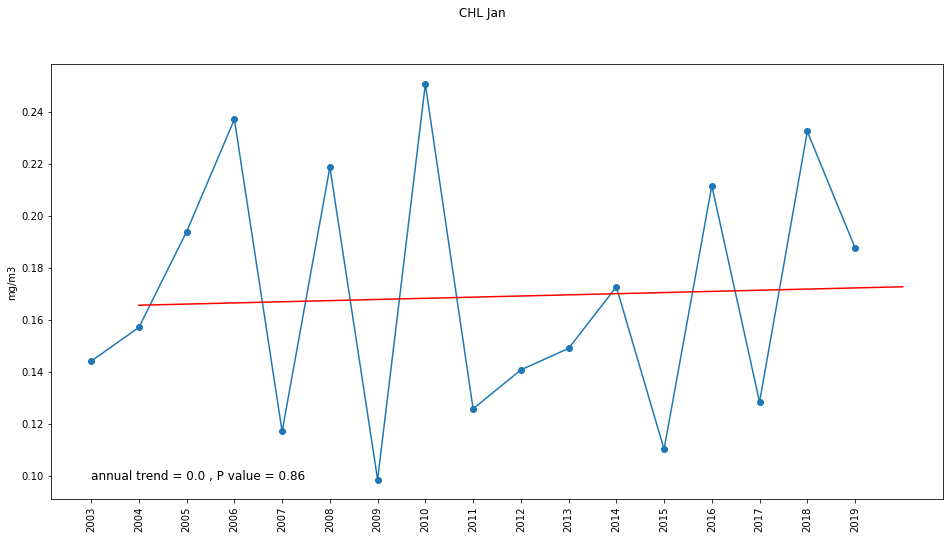

In [89]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,JanmeanICHLDF['mean'].size+1,1)
JanmeanICHLDF['ind'] = ind

JanmeanIFit = sm.ols(formula='mean ~ ind', data=JanmeanICHLDF).fit()
print(JanmeanIFit.summary())

predict = JanmeanIFit.predict(JanmeanICHLDF)
JanmeanICHLDF['fitted'] = predict

rate = round(JanmeanIFit.params[1],3)
pValue = round(JanmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = JanmeanICHLDF.index[0]
textY = JanmeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(JanmeanICHLDF.index.values,JanmeanICHLDF['mean'].values,marker='o')


ax.plot(JanmeanICHLDF.ind, JanmeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Jan')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                    0.3880
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.543
Time:                        10:07:11   Log-Likelihood:                 31.014
No. Observations:                  17   AIC:                            -58.03
Df Residuals:                      15   BIC:                            -56.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1751      0.021      8.308      0.0

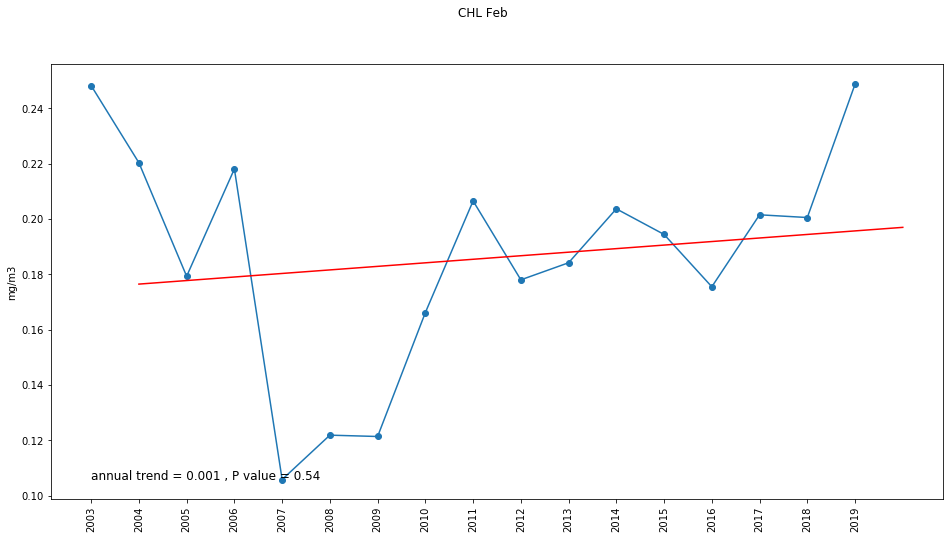

In [90]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,FebmeanICHLDF['mean'].size+1,1)
FebmeanICHLDF['ind'] = ind

FebmeanIFit = sm.ols(formula='mean ~ ind', data=FebmeanICHLDF).fit()
print(FebmeanIFit.summary())

predict = FebmeanIFit.predict(FebmeanICHLDF)
FebmeanICHLDF['fitted'] = predict

rate = round(FebmeanIFit.params[1],3)
pValue = round(FebmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = FebmeanICHLDF.index[0]
textY = FebmeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(FebmeanICHLDF.index.values,FebmeanICHLDF['mean'].values,marker='o')


ax.plot(FebmeanICHLDF.ind, FebmeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Feb')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.396
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.256
Time:                        10:07:19   Log-Likelihood:                 29.311
No. Observations:                  17   AIC:                            -54.62
Df Residuals:                      15   BIC:                            -52.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2394      0.023     10.275      0.0

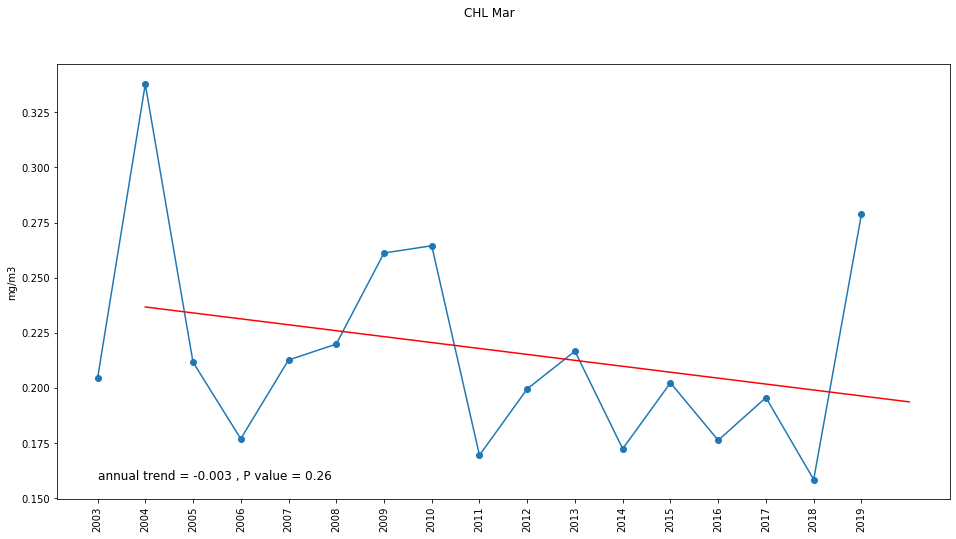

In [91]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,MarmeanICHLDF['mean'].size+1,1)
MarmeanICHLDF['ind'] = ind

MarmeanIFit = sm.ols(formula='mean ~ ind', data=MarmeanICHLDF).fit()
print(MarmeanIFit.summary())

predict = MarmeanIFit.predict(MarmeanICHLDF)
MarmeanICHLDF['fitted'] = predict

rate = round(MarmeanIFit.params[1],3)
pValue = round(MarmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = MarmeanICHLDF.index[0]
textY = MarmeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(MarmeanICHLDF.index.values,MarmeanICHLDF['mean'].values,marker='o')


ax.plot(MarmeanICHLDF.ind, MarmeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Mar')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                    0.3701
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.552
Time:                        10:07:34   Log-Likelihood:                 23.758
No. Observations:                  17   AIC:                            -43.52
Df Residuals:                      15   BIC:                            -41.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2521      0.032      7.802      0.0

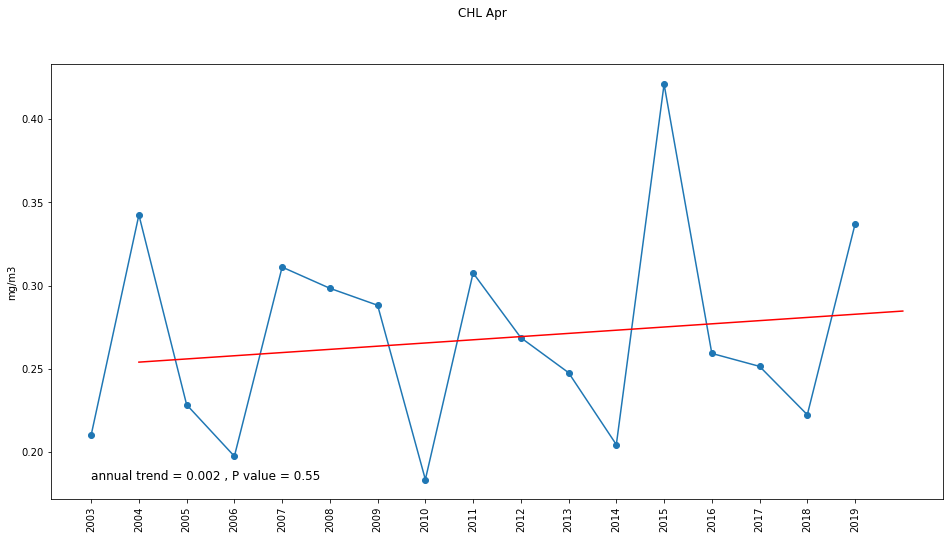

In [93]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,AprmeanICHLDF['mean'].size+1,1)
AprmeanICHLDF['ind'] = ind

AprmeanIFit = sm.ols(formula='mean ~ ind', data=AprmeanICHLDF).fit()
print(AprmeanIFit.summary())

predict = AprmeanIFit.predict(AprmeanICHLDF)
AprmeanICHLDF['fitted'] = predict

rate = round(AprmeanIFit.params[1],3)
pValue = round(AprmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = AprmeanICHLDF.index[0]
textY = AprmeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(AprmeanICHLDF.index.values,AprmeanICHLDF['mean'].values,marker='o')


ax.plot(AprmeanICHLDF.ind, AprmeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Apr')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.5541
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.468
Time:                        10:07:42   Log-Likelihood:                 19.605
No. Observations:                  17   AIC:                            -35.21
Df Residuals:                      15   BIC:                            -33.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3609      0.041      8.749      0.0

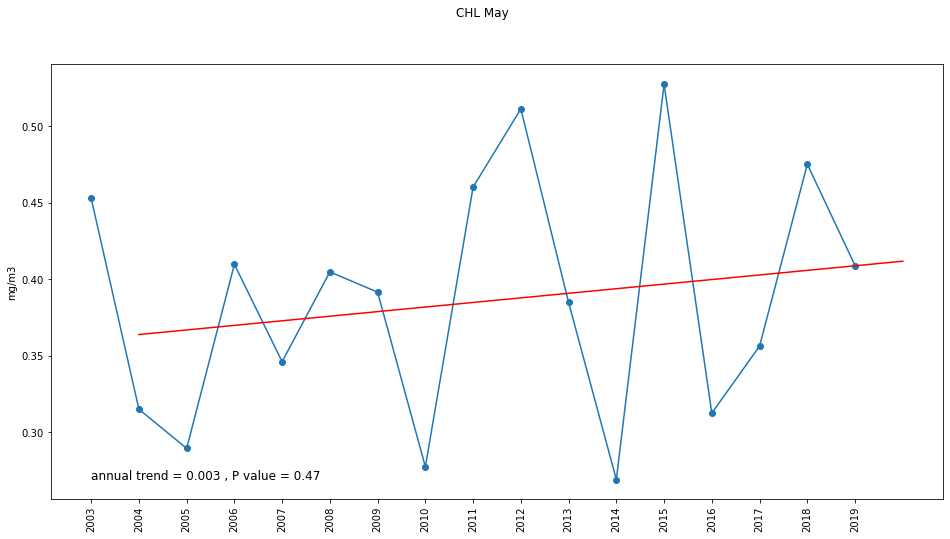

In [94]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,MaymeanICHLDF['mean'].size+1,1)
MaymeanICHLDF['ind'] = ind

MaymeanIFit = sm.ols(formula='mean ~ ind', data=MaymeanICHLDF).fit()
print(MaymeanIFit.summary())

predict = MaymeanIFit.predict(MaymeanICHLDF)
MaymeanICHLDF['fitted'] = predict

rate = round(MaymeanIFit.params[1],3)
pValue = round(MaymeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = MaymeanICHLDF.index[0]
textY = MaymeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(MaymeanICHLDF.index.values,MaymeanICHLDF['mean'].values,marker='o')


ax.plot(MaymeanICHLDF.ind, MaymeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL May')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                    0.4426
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.516
Time:                        10:07:52   Log-Likelihood:                 12.750
No. Observations:                  17   AIC:                            -21.50
Df Residuals:                      15   BIC:                            -19.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5477      0.062      8.872      0.0

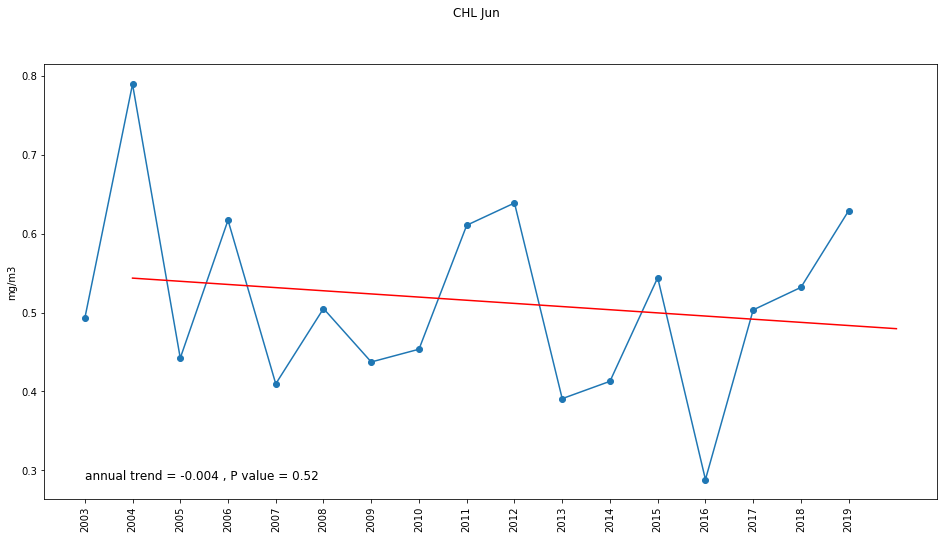

In [95]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,JunmeanICHLDF['mean'].size+1,1)
JunmeanICHLDF['ind'] = ind

JunmeanIFit = sm.ols(formula='mean ~ ind', data=JunmeanICHLDF).fit()
print(JunmeanIFit.summary())

predict = JunmeanIFit.predict(JunmeanICHLDF)
JunmeanICHLDF['fitted'] = predict

rate = round(JunmeanIFit.params[1],3)
pValue = round(JunmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = JunmeanICHLDF.index[0]
textY = JunmeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(JunmeanICHLDF.index.values,JunmeanICHLDF['mean'].values,marker='o')


ax.plot(JunmeanICHLDF.ind, JunmeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Jun')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                    0.2726
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.609
Time:                        10:08:00   Log-Likelihood:                 23.155
No. Observations:                  18   AIC:                            -42.31
Df Residuals:                      16   BIC:                            -40.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5438      0.035     15.597      0.0

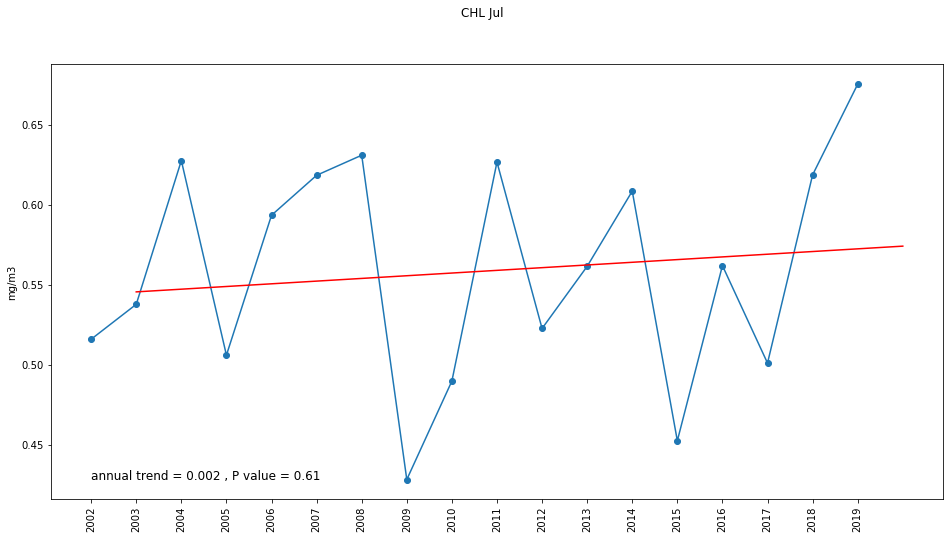

In [96]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,JulmeanICHLDF['mean'].size+1,1)
JulmeanICHLDF['ind'] = ind

JulmeanIFit = sm.ols(formula='mean ~ ind', data=JulmeanICHLDF).fit()
print(JulmeanIFit.summary())

predict = JulmeanIFit.predict(JulmeanICHLDF)
JulmeanICHLDF['fitted'] = predict

rate = round(JulmeanIFit.params[1],3)
pValue = round(JulmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = JulmeanICHLDF.index[0]
textY = JulmeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(JulmeanICHLDF.index.values,JulmeanICHLDF['mean'].values,marker='o')


ax.plot(JulmeanICHLDF.ind, JulmeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Jul')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]

                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.057
Method:                 Least Squares   F-statistic:                    0.1429
Date:                Thu, 13 Feb 2020   Prob (F-statistic):              0.711
Time:                        15:15:21   Log-Likelihood:                 19.515
No. Observations:                  17   AIC:                            -35.03
Df Residuals:                      15   BIC:                            -33.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4144      0.041      9.994      0.0

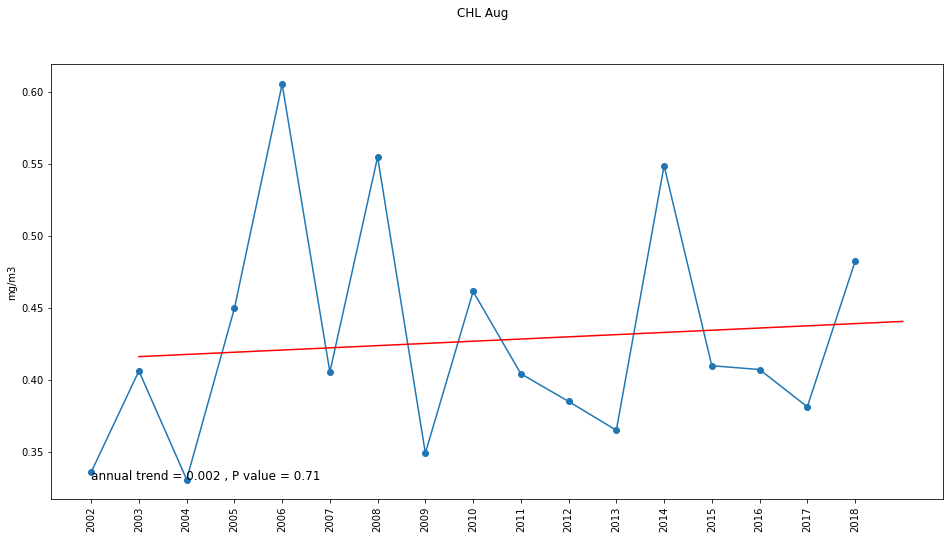

In [31]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,AugmeanICHLDF['mean'].size+1,1)
AugmeanICHLDF['ind'] = ind

AugmeanIFit = sm.ols(formula='mean ~ ind', data=AugmeanICHLDF).fit()
print(AugmeanIFit.summary())

predict = AugmeanIFit.predict(AugmeanICHLDF)
AugmeanICHLDF['fitted'] = predict

rate = round(AugmeanIFit.params[1],3)
pValue = round(AugmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = AugmeanICHLDF.index[0]
textY = AugmeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(AugmeanICHLDF.index.values,AugmeanICHLDF['mean'].values,marker='o')


ax.plot(AugmeanICHLDF.ind, AugmeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Aug')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.4081
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.533
Time:                        10:08:14   Log-Likelihood:                 23.544
No. Observations:                  17   AIC:                            -43.09
Df Residuals:                      15   BIC:                            -41.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2601      0.033      7.951      0.0

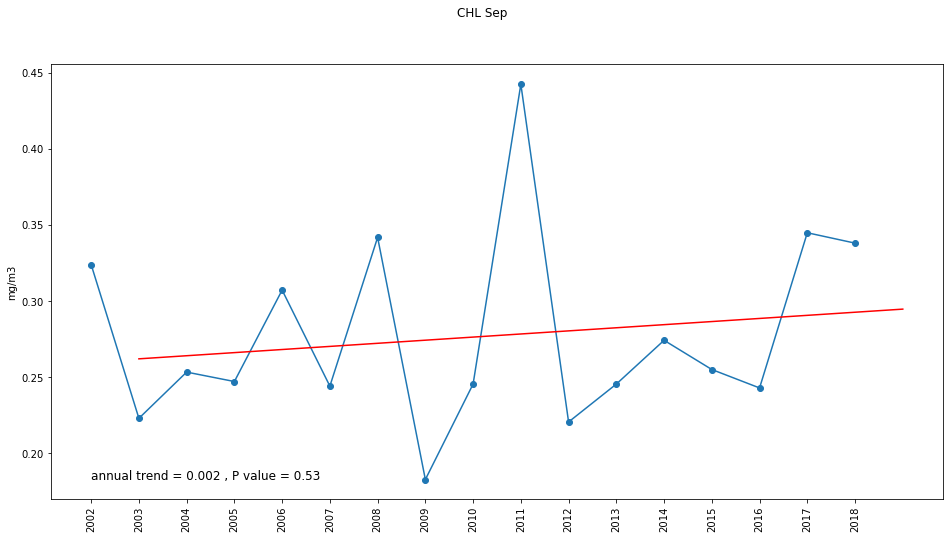

In [98]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,SepmeanICHLDF['mean'].size+1,1)
SepmeanICHLDF['ind'] = ind

SepmeanIFit = sm.ols(formula='mean ~ ind', data=SepmeanICHLDF).fit()
print(SepmeanIFit.summary())

predict = SepmeanIFit.predict(SepmeanICHLDF)
SepmeanICHLDF['fitted'] = predict

rate = round(SepmeanIFit.params[1],3)
pValue = round(SepmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = SepmeanICHLDF.index[0]
textY = SepmeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(SepmeanICHLDF.index.values,SepmeanICHLDF['mean'].values,marker='o')


ax.plot(SepmeanICHLDF.ind, SepmeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Sep')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.060
Method:                 Least Squares   F-statistic:                   0.09834
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.758
Time:                        10:08:22   Log-Likelihood:                 22.359
No. Observations:                  17   AIC:                            -40.72
Df Residuals:                      15   BIC:                            -39.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2424      0.035      6.911      0.0

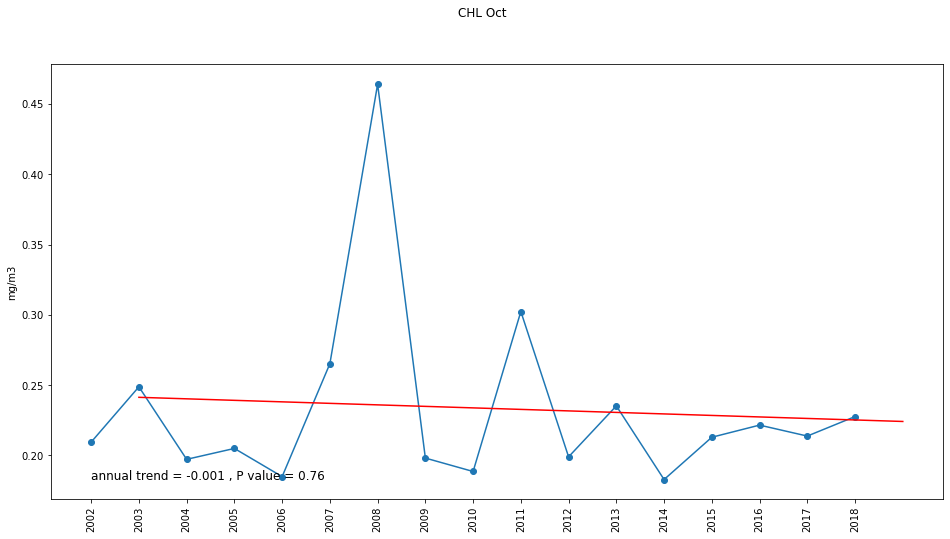

In [99]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,OctmeanICHLDF['mean'].size+1,1)
OctmeanICHLDF['ind'] = ind

OctmeanIFit = sm.ols(formula='mean ~ ind', data=OctmeanICHLDF).fit()
print(OctmeanIFit.summary())

predict = OctmeanIFit.predict(OctmeanICHLDF)
OctmeanICHLDF['fitted'] = predict

rate = round(OctmeanIFit.params[1],3)
pValue = round(OctmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = OctmeanICHLDF.index[0]
textY = OctmeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(OctmeanICHLDF.index.values,OctmeanICHLDF['mean'].values,marker='o')


ax.plot(OctmeanICHLDF.ind, OctmeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Oct')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     1.699
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.212
Time:                        10:08:29   Log-Likelihood:                 33.489
No. Observations:                  17   AIC:                            -62.98
Df Residuals:                      15   BIC:                            -61.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1682      0.018      9.231      0.0

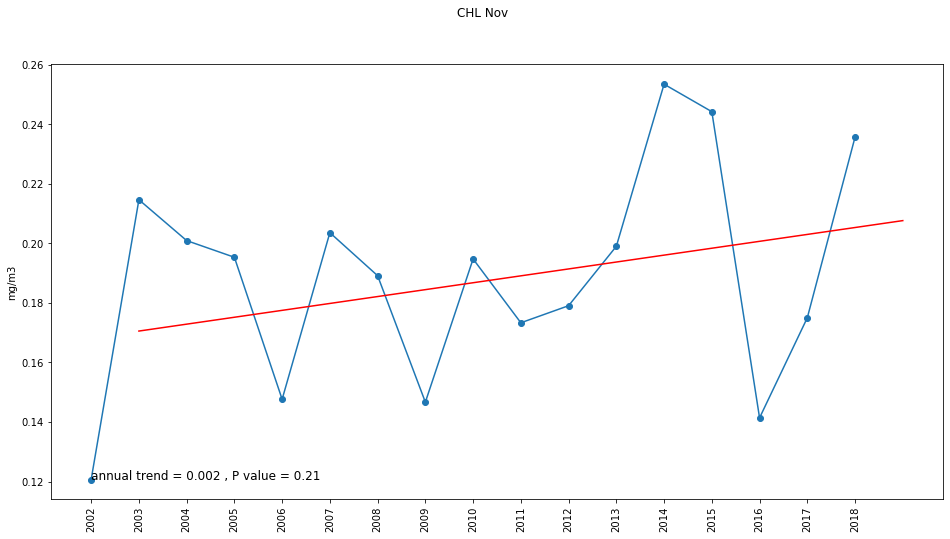

In [100]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,NovmeanICHLDF['mean'].size+1,1)
NovmeanICHLDF['ind'] = ind

NovmeanIFit = sm.ols(formula='mean ~ ind', data=NovmeanICHLDF).fit()
print(NovmeanIFit.summary())

predict = NovmeanIFit.predict(NovmeanICHLDF)
NovmeanICHLDF['fitted'] = predict

rate = round(NovmeanIFit.params[1],3)
pValue = round(NovmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = NovmeanICHLDF.index[0]
textY = NovmeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(NovmeanICHLDF.index.values,NovmeanICHLDF['mean'].values,marker='o')


ax.plot(NovmeanICHLDF.ind, NovmeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Nov')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.066
Method:                 Least Squares   F-statistic:                  0.006780
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.935
Time:                        10:08:41   Log-Likelihood:                 20.500
No. Observations:                  17   AIC:                            -37.00
Df Residuals:                      15   BIC:                            -35.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1811      0.039      4.628      0.0

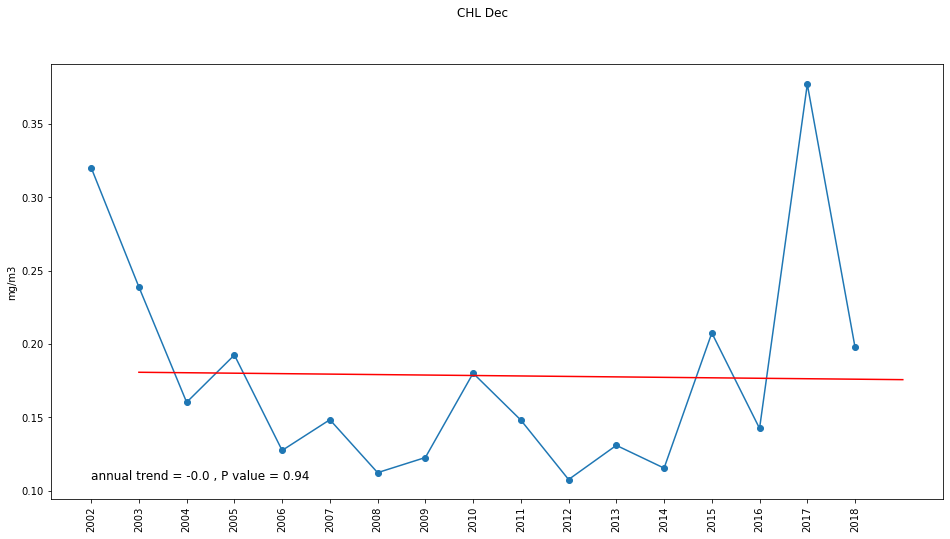

In [101]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,DecmeanICHLDF['mean'].size+1,1)
DecmeanICHLDF['ind'] = ind

DecmeanIFit = sm.ols(formula='mean ~ ind', data=DecmeanICHLDF).fit()
print(DecmeanIFit.summary())

predict = DecmeanIFit.predict(DecmeanICHLDF)
DecmeanICHLDF['fitted'] = predict

rate = round(DecmeanIFit.params[1],3)
pValue = round(DecmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = DecmeanICHLDF.index[0]
textY = DecmeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(DecmeanICHLDF.index.values,DecmeanICHLDF['mean'].values,marker='o')


ax.plot(DecmeanICHLDF.ind, DecmeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Dec')

plt.show()

**annual time-series of each season**

In [32]:
meanIDF = chlDF[['meanI','year','season']]
x = meanIDF.groupby(['year','season'])
yearseasonmeanICHLDF = x.describe()

idx = pd.IndexSlice
SummermeanICHLDF = yearseasonmeanICHLDF.loc[idx[:,['summer']],:]
AutumnmeanICHLDF = yearseasonmeanICHLDF.loc[idx[:,['autumn']],:]
WintermeanICHLDF = yearseasonmeanICHLDF.loc[idx[:,['winter']],:]
SpringmeanICHLDF = yearseasonmeanICHLDF.loc[idx[:,['spring']],:]

SummermeanICHLDF.reset_index(inplace=True)
SummermeanICHLDF.set_index('year',inplace=True)
x = SummermeanICHLDF.columns.droplevel(level=0)
SummermeanICHLDF.columns=x
AutumnmeanICHLDF.reset_index(inplace=True)
AutumnmeanICHLDF.set_index('year',inplace=True)
x = AutumnmeanICHLDF.columns.droplevel(level=0)
AutumnmeanICHLDF.columns=x
WintermeanICHLDF.reset_index(inplace=True)
WintermeanICHLDF.set_index('year',inplace=True)
x = WintermeanICHLDF.columns.droplevel(level=0)
WintermeanICHLDF.columns=x
SpringmeanICHLDF.reset_index(inplace=True)
SpringmeanICHLDF.set_index('year',inplace=True)
x = SpringmeanICHLDF.columns.droplevel(level=0)
SpringmeanICHLDF.columns=x


In [33]:
SummermeanICHLDF1 = SummermeanICHLDF.loc['2003':'2018']

WintermeanICHLDF1 = WintermeanICHLDF.loc['2003':'2018']

**plot and fit annual time-series of the seasonal means**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.3676
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.554
Time:                        10:09:08   Log-Likelihood:                 32.639
No. Observations:                  16   AIC:                            -61.28
Df Residuals:                      14   BIC:                            -59.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1637      0.018      9.281      0.0

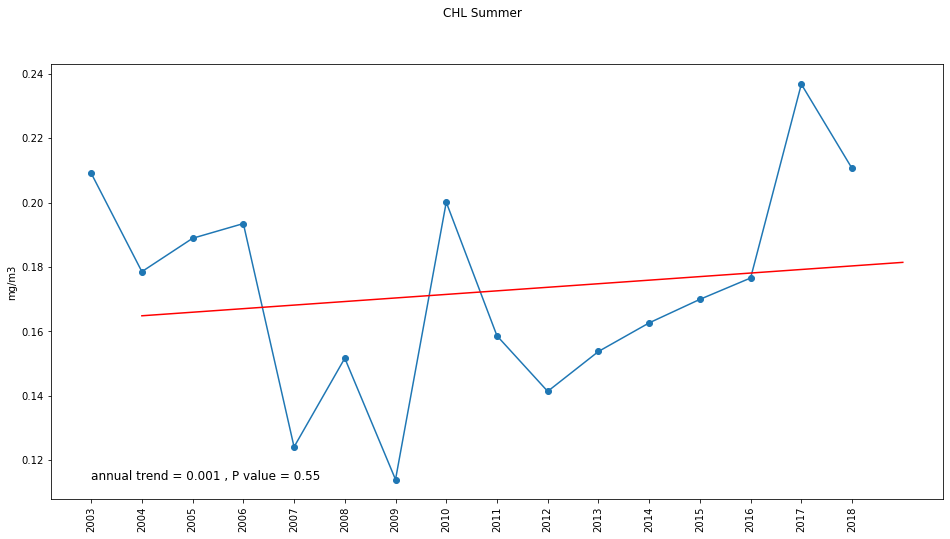

In [102]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,SummermeanICHLDF1['mean'].size+1,1)
SummermeanICHLDF1['ind'] = ind

SummermeanIFit = sm.ols(formula='mean ~ ind', data=SummermeanICHLDF1).fit()
print(SummermeanIFit.summary())

predict = SummermeanIFit.predict(SummermeanICHLDF1)
SummermeanICHLDF1['fitted'] = predict

rate = round(SummermeanIFit.params[1],3)
pValue = round(SummermeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = SummermeanICHLDF1.index[0]
textY = SummermeanICHLDF1['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(SummermeanICHLDF1.index.values,SummermeanICHLDF1['mean'].values,marker='o')


ax.plot(SummermeanICHLDF1.ind, SummermeanICHLDF1.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Summer')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.059
Method:                 Least Squares   F-statistic:                    0.1140
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.740
Time:                        10:09:20   Log-Likelihood:                 30.173
No. Observations:                  17   AIC:                            -56.35
Df Residuals:                      15   BIC:                            -54.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2845      0.022     12.842      0.0

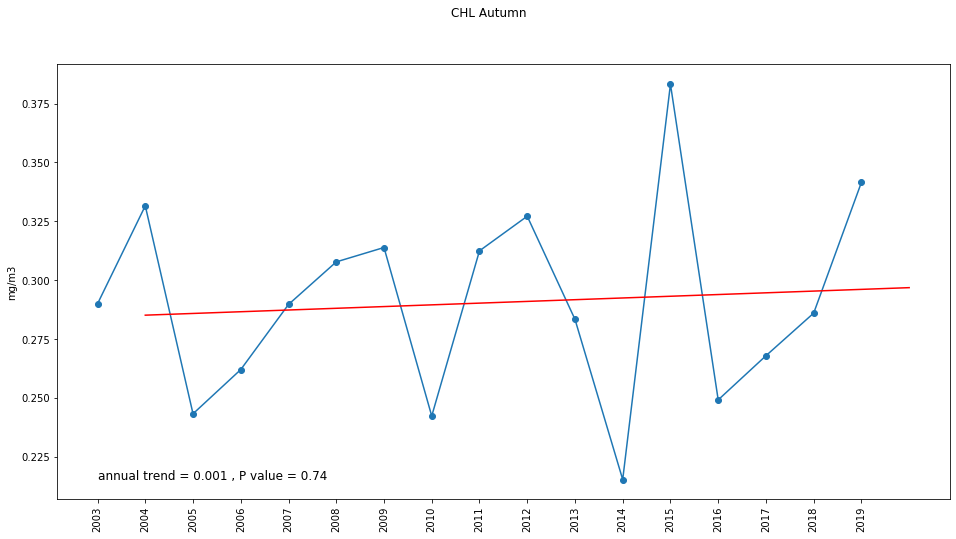

In [103]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,AutumnmeanICHLDF['mean'].size+1,1)
AutumnmeanICHLDF['ind'] = ind

AutumnmeanIFit = sm.ols(formula='mean ~ ind', data=AutumnmeanICHLDF).fit()
print(AutumnmeanIFit.summary())

predict = AutumnmeanIFit.predict(AutumnmeanICHLDF)
AutumnmeanICHLDF['fitted'] = predict

rate = round(AutumnmeanIFit.params[1],3)
pValue = round(AutumnmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = AutumnmeanICHLDF.index[0]
textY = AutumnmeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(AutumnmeanICHLDF.index.values,AutumnmeanICHLDF['mean'].values,marker='o')


ax.plot(AutumnmeanICHLDF.ind, AutumnmeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Autumn')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.041
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.325
Time:                        10:09:28   Log-Likelihood:                 23.825
No. Observations:                  16   AIC:                            -43.65
Df Residuals:                      14   BIC:                            -42.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5253      0.031     17.165      0.0

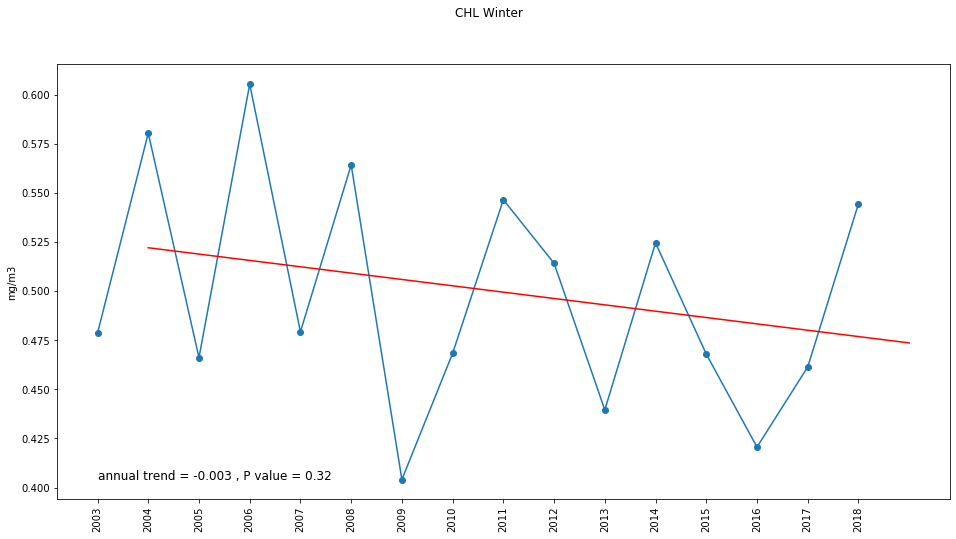

In [104]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,WintermeanICHLDF1['mean'].size+1,1)
WintermeanICHLDF1['ind'] = ind

WintermeanIFit = sm.ols(formula='mean ~ ind', data=WintermeanICHLDF1).fit()
print(WintermeanIFit.summary())

predict = WintermeanIFit.predict(WintermeanICHLDF1)
WintermeanICHLDF1['fitted'] = predict

rate = round(WintermeanIFit.params[1],3)
pValue = round(WintermeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = WintermeanICHLDF1.index[0]
textY = WintermeanICHLDF1['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(WintermeanICHLDF1.index.values,WintermeanICHLDF1['mean'].values,marker='o')


ax.plot(WintermeanICHLDF1.ind, WintermeanICHLDF1.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Winter')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.046
Method:                 Least Squares   F-statistic:                    0.3015
Date:                Thu, 30 Jan 2020   Prob (F-statistic):              0.591
Time:                        10:09:38   Log-Likelihood:                 31.918
No. Observations:                  17   AIC:                            -59.84
Df Residuals:                      15   BIC:                            -58.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2238      0.020     11.196      0.0

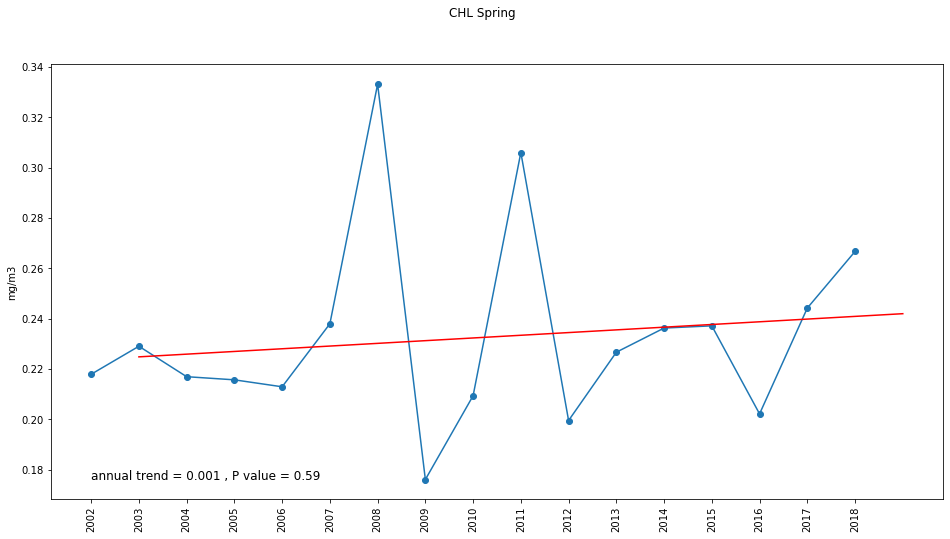

In [105]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,SpringmeanICHLDF['mean'].size+1,1)
SpringmeanICHLDF['ind'] = ind

SpringmeanIFit = sm.ols(formula='mean ~ ind', data=SpringmeanICHLDF).fit()
print(SpringmeanIFit.summary())

predict = SpringmeanIFit.predict(SpringmeanICHLDF)
SpringmeanICHLDF['fitted'] = predict

rate = round(SpringmeanIFit.params[1],3)
pValue = round(SpringmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = SpringmeanICHLDF.index[0]
textY = SpringmeanICHLDF['mean'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(SpringmeanICHLDF.index.values,SpringmeanICHLDF['mean'].values,marker='o')


ax.plot(SpringmeanICHLDF.ind, SpringmeanICHLDF.fitted, 'r')
ax.set_ylabel('mg/m3')
fig.suptitle('CHL Spring')

plt.show()

**annual trend on the number of high-productivity days each year**

**A high-productivity day is defined as a day with a mean CHL value greater than the 95% percentile of the whole time-series (all days in all years)**

In [63]:
productivedaysDF = pd.DataFrame()
productivedaysList = []
yearList = chlDF.year.unique() # get unique values in a column
p95 = chlDF['meanI'].quantile(0.95) # get 95% percentile of the entire time-series
print(p95)
for year in yearList:    
    tempDF = chlDF[chlDF['year'] == year]
    
    productivedays = (tempDF['meanI'] > p95).sum()
   
    productivedaysList.append(productivedays)
productivedaysDF['year'] = yearList
productivedaysDF['productivedays'] = productivedaysList
productivedaysDF.set_index('year',inplace=True)

0.6500125240662666


In [64]:
productivedaysDF

,productivedays
year,
2002,9
2003,13
2004,25
2005,4
2006,29
2007,15
2008,27
2009,5
2010,8


In [67]:
productivedaysDF1 = productivedaysDF.loc['2003':'2018']

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:         productivedays   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.071
Method:                 Least Squares   F-statistic:                  0.002842
Date:                Tue, 25 Feb 2020   Prob (F-statistic):              0.958
Time:                        11:53:15   Log-Likelihood:                -57.064
No. Observations:                  16   AIC:                             118.1
Df Residuals:                      14   BIC:                             119.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.8500      4.801      3.718      0.0

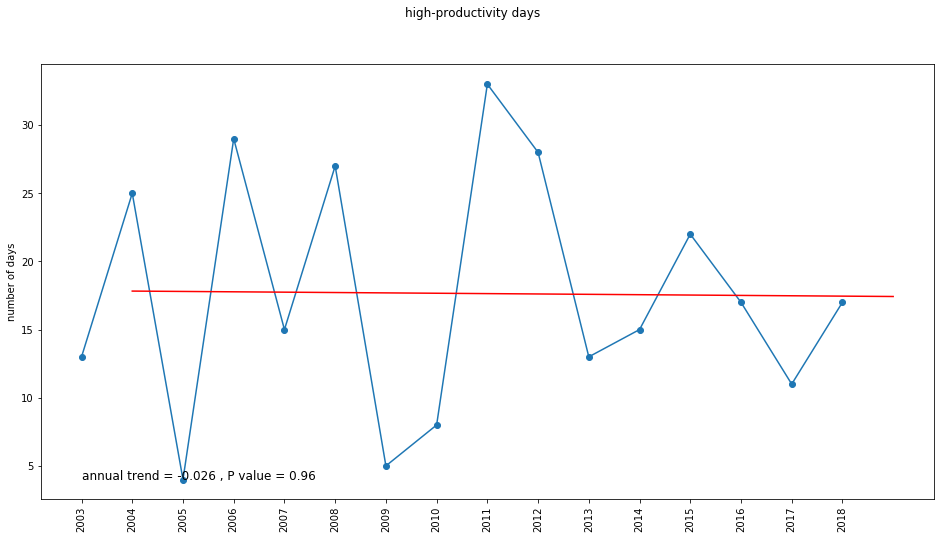

In [68]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,productivedaysDF1.index.size+1,1)
productivedaysDF1['ind'] = ind

productivedaysIFit = sm.ols(formula='productivedays ~ ind', data=productivedaysDF1).fit()
print(productivedaysIFit.summary())

predict = productivedaysIFit.predict(productivedaysDF1)
productivedaysDF1['fitted'] = predict

rate = round(productivedaysIFit.params[1],3)
pValue = round(productivedaysIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = productivedaysDF1.index[0]
textY = productivedaysDF1['productivedays'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(productivedaysDF1.index.values,productivedaysDF1['productivedays'].values,marker='o')


ax.plot(productivedaysDF1.ind, productivedaysDF1.fitted, 'r')
ax.set_ylabel('number of days')
fig.suptitle('high-productivity days')

plt.show()

In [69]:
chlDF['meanI'].mean(),chlDF['meanI'].std()

(0.30174705857199857, 0.20299759320336574)